#**0**. Get node specs

In [31]:
#GPU count and name
!nvidia-smi -L

GPU 0: NVIDIA GeForce RTX 2060 (UUID: GPU-c5ab3c3f-bb9c-1f56-7d2f-ef2d3211e013)


In [32]:
#use this command to see GPU activity while doing Deep Learning tasks, for this command 'nvidia-smi' and for above one to work, go to 'Runtime > change runtime type > Hardware Accelerator > GPU'
!nvidia-smi

Thu Jun 10 18:19:21 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 466.27       Driver Version: 466.27       CUDA Version: 11.3     |
|-------------------------------+----------------------+----------------------+
| GPU  Name            TCC/WDDM | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ... WDDM  | 00000000:01:00.0  On |                  N/A |
| 42%   32C    P8    22W / 160W |   1331MiB /  6144MiB |      2%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [33]:
!lscpu |grep 'Model name'

'lscpu' is not recognized as an internal or external command,
operable program or batch file.


In [34]:
#no.of sockets i.e available slots for physical processors
!lscpu | grep 'Socket(s):'

'lscpu' is not recognized as an internal or external command,
operable program or batch file.


In [35]:
#no.of cores each processor is having 
!lscpu | grep 'Core(s) per socket:'

'lscpu' is not recognized as an internal or external command,
operable program or batch file.


In [36]:
#no.of threads each core is having
!lscpu | grep 'Thread(s) per core'

'lscpu' is not recognized as an internal or external command,
operable program or batch file.


In [37]:
!lscpu | grep "L3 cache" 

'lscpu' is not recognized as an internal or external command,
operable program or batch file.


In [ ]:
#if it had turbo boost it would've shown Min and Max MHz also but it is only showing current frequency this means it always operates at 2.3GHz
!lscpu | grep "MHz"

CPU MHz:             2299.998


In [ ]:
#memory that we can use
# !free -h --si | awk  '/Mem:/{print $2}'
!free -h --si 

              total        used        free      shared  buff/cache   available
Mem:            37G        1.0G         34G        1.0M        2.0G         35G
Swap:            0B          0B          0B


## **1**. Imports

In [7]:
import os
BASEDIR = os.getcwd() + "/"
dirs = ["src","results","model","data"]
for dirc in dirs:
	if dirc not in os.listdir(): 
		os.makedirs(os.path.join(BASEDIR,dirc))
PYTHONDIR=BASEDIR+'src/'
RESULTSDIR=BASEDIR+'results/'
MODELSDIR=BASEDIR+'model/'
DATADIR=BASEDIR+'data/'
subreddit2title = {'depression':'DEP','suicidewatch':'SUI','anxiety':'ANX','bipolar':'BIP'}

In [8]:
# TODO: explain each of the variables below 

EXTENSION = '.pkl'
STRATIFIED = True  # If true, will apply a stratified K-fold cross-validation to the dataset.
TRAIN = True # If true, will train the models

USE_GRU = True # If true, will use the GRU RNN model in training
USE_XGB = False # If true, will use the XGBoost model in training

GRID_SEARCH_XGB = False # If true, will do a grid search for the XGBoost model
PLOT_XGB = False # If true, will plot the results found by the XGBoost model(Only available if TRAIN = True)

TEST  = False # If true, will test the models

ZNORMALIZE = False # If true, will apply a z-normalization to the dataset


KEEP_TEXT = True # If true, allow to visualize content from posts and comments

# SUBREDDITS  = ['Anxiety','bipolar','depression','SuicideWatch'] 
SUBREDDITS  = ['Anxiety'] 

assert TRAIN ^ TEST # either TRAIN or TEST

FILTERED=True # If true
BIN_WIDTH=0.2 # Controls the width of the bins used to calculate the weighted L1 loss
MIN_VALUE = -1 # Controls the minimum output value(set to -1)


INCLUDE_TARGET = 0
INCLUDE_THREAD_COMMENTS = 0


MAX_BRANCH_LEN = 16   # not including authors' last comment
MAX_THREAD_LEN = 64   # not including authors' last comment

In [9]:
import torch
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
if device == torch.device('cuda'):
    print(f"Device successfully set to cuda")
else:
    print("WARNING! DEVICE IS NOT SET TO CUDA")

print(torch.__version__)

Device successfully set to cuda
1.8.1+cu111


In [10]:
import sys
# sys.path.append(PYTHONDIR)

import random
import pickle
import time
import pdb
import importlib
import itertools
import pprint
import copy
import os

import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
from sklearn.model_selection import GridSearchCV,train_test_split
from sklearn.metrics import mean_squared_error

from tqdm.notebook import tqdm
from scipy import stats

import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F

from xgboost import XGBRegressor, Booster, DMatrix

# imports from src package
from src import models
from src import pytorchtools

In [11]:
from src.utils import reset_seeds, count_parameters, evaluate, train_over_nepochs, createTensorDataset
from src.training_functions import load_df, compute_bin_weights, save_stats_tensors, load_stats_tensors, get_znorm_params, get_subreddit_range, split_indices, get_subreddit_weights, get_baselines_df, WeightedL1Loss, WeightedMSELoss, grid_search_train
from torch.utils.data import Dataset, TensorDataset, DataLoader, random_split, Sampler, SubsetRandomSampler, Subset



#**2**. Creating a RedditDataset or TensorDataset instance

Instead of using a custom Dataset class (former ```RedditDataset```), we store the data required by the experiments in a ```TensorDataset``` to speed up the retrieval of the batchs.

```set_threads``` is a list of indexes containing the threads to be used as a dataset.

## **2.1** Choose strategy to build the source data

* Strategy 1: Predict based on specific branch within a discussion tree
* Strategy 2: Predict based on the sequence of comments in a thread
* Strategy 3: Predict based on specific branch, but use all the sequence of comments in a thread up to that point in time as side information

In [12]:
suffix='_distilbert_filtered_posts' + EXTENSION
df_list = {subreddit:load_df(DATADIR+subreddit+suffix, MAX_THREAD_LEN) \
           for subreddit in SUBREDDITS}

post_df = pd.concat((df_list[subreddit] for subreddit in SUBREDDITS), keys=SUBREDDITS)
del df_list

Loading D:\FGCS/data/Anxiety_distilbert_filtered_posts.pkl...


In [13]:
# TODO: it seems that we are keeping everything if KEEP_TEXT. is this really necessary?
if not KEEP_TEXT:
  post_df = post_df[['created_utc', 'seq_len','score', 'features', 'filtered_seqlen','valid_branches']]

# new strategy to construct observations: follow branches of every discussion tree 
#post_df.drop(columns=['valid_branches'],inplace=True)

if FILTERED:
    # dropna on filtered_seqlen, then replace seq_len by filtered_seqlen
    post_df.dropna(subset=['filtered_seqlen'], inplace=True)
    post_df.filtered_seqlen = post_df.filtered_seqlen.astype(int)

    post_df.drop(columns='seq_len',inplace=True)
    post_df.rename(columns={'filtered_seqlen':'seq_len'},inplace=True)
else:
    post_df.drop(columns='filtered_seqlen',inplace=True)

print(f'Fraction of threads that had to be truncated: {(post_df.seq_len>(MAX_THREAD_LEN+1)).mean()}')


Fraction of threads that had to be truncated: 0.002425560388089662


In [14]:
# TODO: define constants upfront
if ZNORMALIZE:
  prefix = ''
else:
  prefix = 'unnorm_'

# TODO: place z-normalization in a new function and explain what it does

if TRAIN:
  if ZNORMALIZE:
    src_m, src_s = get_znorm_params(post_df)
  else:
    shape = [1,post_df.iloc[0].features.shape[-1]]
    src_m = torch.zeros(shape)
    src_s = torch.ones(shape)

  save_stats_tensors(src_m,src_s,f'{BASEDIR}data/{prefix}')
  
if TEST:
  src_m, src_s = load_stats_tensors(f'{BASEDIR}data/{prefix}')

score_m = float(src_m[0,-2])
score_s = float(src_s[0,-2])

print(f'Average score in dataset is {score_m}')

subreddit2range = get_subreddit_range(post_df)
print(subreddit2range[SUBREDDITS[0]])

# TODO: define constants upfront
suffix = "random"
if STRATIFIED:
  suffix += '_strat'

# TODO: place indexing in a new function and explain what it does
# get indices
if TRAIN:
  if len(SUBREDDITS) == 4:
      train_inds, valid_inds, test_inds  = split_indices(post_df)
  else:
    subreddit = SUBREDDITS[0]
    with open(f'{DATADIR}{subreddit}_{suffix}_splits.pkl','rb') as infile:
      splits = pickle.load(infile)
      train_locs =  [(subreddit,loc) for loc in splits[0]]
      valid_locs =  [(subreddit,loc) for loc in splits[1]]
      test_locs  =  [(subreddit,loc) for loc in splits[2]]

    train_inds = post_df.index.get_indexer_for(train_locs)
    valid_inds = post_df.index.get_indexer_for(valid_locs)
    test_inds  = post_df.index.get_indexer_for(test_locs)


if TEST:
  train_locs = []
  valid_locs = []
  test_locs  = []
  for subreddit in SUBREDDITS:
      with open(f'{DATADIR}{subreddit}_{suffix}_splits.pkl','rb') as infile:
        splits = pickle.load(infile)
        test_locs += [(subreddit,loc) for loc in splits[2]]

  # extract instances
  print(len(post_df))
  post_df = post_df.loc[test_locs]
  print(len(post_df))

# compute weights for Weighted L1 Loss
subreddit2weights = get_subreddit_weights(post_df, BIN_WIDTH,MIN_VALUE,device)
print(subreddit2weights)


Average score in dataset is 0.0
slice(0, 11956, None)
{'all': tensor([42.7000, 17.7126,  7.0123,  3.0040,  1.3743,  0.7531,  0.8850,  1.2454,
         2.8535,  9.4514], device='cuda:0'), 'Anxiety': tensor([42.7000, 17.7126,  7.0123,  3.0040,  1.3743,  0.7531,  0.8850,  1.2454,
         2.8535,  9.4514], device='cuda:0')}


In [15]:
%%time

# TODO: place the dataset generation in a function


print('Creating src')

print('Creating y')
y = torch.Tensor(post_df.apply(lambda p: p.score[p.seq_len-1], axis=1).values)

print('Creating src_len_series')
src_len_series = post_df.seq_len-1
max_length=MAX_THREAD_LEN

if USE_GRU:
    src = nn.utils.rnn.pad_sequence(
    [ p.features[:min(MAX_THREAD_LEN,p.seq_len-1),:] for index, p in post_df.iterrows()], batch_first=True)
    # src = nn.utils.rnn.pad_sequence(
    # [ (p.features[:min(MAX_THREAD_LEN,p.seq_len-1),:]-src_m)/src_s for index, p in post_df.iterrows()], batch_first=True)
    print(f"GRU src tensor size: {src.size()}")

if USE_XGB:      
    src_xgb = torch.cat((
        torch.cat([torch.mean((p.features[:min(MAX_THREAD_LEN,p.seq_len-1),:]-src_m)/src_s,keepdims=True,dim=0) for index, p in post_df.iterrows()],axis=0),
        torch.cat([torch.max((p.features[:min(MAX_THREAD_LEN,p.seq_len-1),:]-src_m)/src_s,keepdims=True,dim=0)[0] for index, p in post_df.iterrows()],axis=0)
        ),1)
    print(f"XGB src tensor size: {src_xgb.size()}")


print(f'y tensor size: {y.size()}')


if INCLUDE_TARGET:
  tgt = nn.utils.rnn.pad_sequence(
    [(p.features[b[-2]]-src_m)/src_s for index, p in post_df.iterrows() for b in p.valid_branches],
  batch_first=True)
else:
  tgt = None

  # clean up memory
  #if (not TEST) and (not KEEP_TEXT):
  if (not KEEP_TEXT):
    del post_df

  print('Creating dataset')
  if USE_GRU:
    #dataset = createTensorDataset(src, src_len_series, y, tgt=tgt, max_length=max_length) # all threads, lim 63 comments
    dataset = createTensorDataset(src, src_len_series, y, max_length=max_length) # all threads, lim 63 comments
    del src
  if USE_XGB:
    dataset_xgb = createTensorDataset(src_xgb, src_len_series, y, max_length=max_length)
    del src_xgb
  
  del src_len_series, tgt, y

Creating src
Creating y
Creating src_len_series
GRU src tensor size: torch.Size([11956, 64, 770])
y tensor size: torch.Size([11956])
Creating dataset
Wall time: 1.4 s


In [16]:
# TODO: can we get EMBEDDING_DIM earlier, from post_df?

if USE_GRU:
  batch = dataset[0]
  EMBEDDING_DIM = batch[0].shape[-1]
  print(f"embedding dimension for GRU: {EMBEDDING_DIM}")
if USE_XGB:
  batch = dataset_xgb[0]
  EMBEDDING_DIM_XGB = batch[0].shape[-1]
  print(f"embedding dimension for XGB: {EMBEDDING_DIM_XGB}")

embedding dimension for GRU: 770


##**2.2** Create training, validation and test sets

In [17]:
#%%time

print("Creating dataloaders...")
if TRAIN:
  if USE_XGB:
    train_loader_xgb = DataLoader(Subset(dataset_xgb,train_inds), batch_size=len(train_inds), shuffle=True, num_workers=0)
    valid_loader_xgb = DataLoader(Subset(dataset_xgb,valid_inds), batch_size=len(valid_inds), shuffle=False, num_workers=0)
    test_loader_xgb  = DataLoader(Subset(dataset_xgb, test_inds), batch_size=len(test_inds), shuffle=False, num_workers=1) 

  if USE_GRU: 
      train_loader = DataLoader(Subset(dataset,train_inds), batch_size=32, shuffle=True, num_workers=1)
      valid_loader = DataLoader(Subset(dataset,valid_inds), batch_size=len(valid_inds), shuffle=False, num_workers=1)
      test_loader  = DataLoader(Subset(dataset, test_inds), batch_size=len(test_inds), shuffle=False, num_workers=1)


if TEST:
  if USE_GRU:
   test_loader  = DataLoader(dataset, batch_size=len(dataset), shuffle=False, num_workers=1)
  if USE_XGB:
    test_loader_xgb  = DataLoader(dataset_xgb, batch_size=len(dataset_xgb), shuffle=False, num_workers=1)


Creating dataloaders...


#**3**. Training the models

## **3.1** (Stacked) (Bi-) GRU model

Takes one source sequence as input.

Example of how to run the model.

In [18]:
# TODO: define the constants upfront; explain what this cell does
N_EPOCHS=20 # maximum number of epochs to train the model
PATIENCE=3 # constant that controls the Early Stopping mechanism of the grid search for the GRU model

# make sure it is a list
if type(SUBREDDITS) != list:
  SUBREDDITS = list(SUBREDDITS)

if TRAIN:
  if len(SUBREDDITS) == 4:
    SRC_DATASET='all'
  if len(SUBREDDITS) == 1:
    SRC_DATASET=SUBREDDITS[0]

if TEST:
  SRC_DATASET='all'
  #SRC_DATASET='whatisthisthing'  
  # SRC_DATASET=SUBREDDITS[0] # use model trained with own dataset

PREFIX ='random'
if STRATIFIED:
  PREFIX += '_strat'

results_filename=f'{RESULTSDIR}{PREFIX}_{SRC_DATASET}_b{int(2./BIN_WIDTH):02}_f{FILTERED}_n{N_EPOCHS}_p{PATIENCE}_mGRUv1.pkl'

#results_filename=f'{DATADIR}{PREFIX}_{SRC_DATASET}_b{int(2./BIN_WIDTH):02}_f{FILTERED}_n{N_EPOCHS}_p{PATIENCE}_mGRUv1.pkl'
print(f'Results file is {results_filename}')

Results file is D:\FGCS/results/random_strat_Anxiety_b10_fTrue_n20_p3_mGRUv1.pkl


In [19]:
%%time

# TODO: explain what this cell does

if TRAIN:

  # test_params
  hidden_size_list     = [4, 16, 64]
  bidirectional_list   = [False, True]
  nlayers_dropout_list = [(1,0.)] + [(2,prob) for prob in [0., .1, .2, .5]]

#   hidden_size_list     = [64]
#   bidirectional_list   = [True]
#   nlayers_dropout_list = [(1,0.)]

  # train and test criteria
  # train_criteria=[nn.L1Loss(),nn.MSELoss(),WeightedL1Loss(),WeightedMSELoss()]
  train_criteria=[WeightedL1Loss( subreddit2weights['all'],BIN_WIDTH, MIN_VALUE)]
  test_criteria =[WeightedL1Loss( subreddit2weights['all'],BIN_WIDTH, MIN_VALUE),
                  WeightedMSELoss(subreddit2weights['all'],BIN_WIDTH, MIN_VALUE),
                  nn.L1Loss(), nn.MSELoss()]

  results_df = grid_search_train(train_loader,valid_loader,hidden_size_list, bidirectional_list, nlayers_dropout_list, train_criteria, test_criteria, results_filename,EMBEDDING_DIM=EMBEDDING_DIM, PLOT=False,N_EPOCHS=N_EPOCHS,PATIENCE=PATIENCE)

L0: criterion: 0it [00:00, ?it/s]
L1: hidden_size: 0it [00:00, ?it/s]

L2: bidirectional: 0it [00:00, ?it/s]

{'input_size': 770, 'output_size': 1, 'uses_two_series_as_input': False, 'dropout_out': 0.0, 'hidden_size': 4, 'num_layers': 1, 'dropout_rnn': 0.0, 'bidirectional': False}


L2: bidirectional: 0it [00:09, ?it/s]
L1: hidden_size: 0it [00:09, ?it/s]
L0: criterion: 0it [00:09, ?it/s]


RuntimeError: expected scalar type Half but found Float

In [ ]:
!rm '/content/drive/My Drive/MentalHealthShared/results/random_strat_Anxiety_b10_fTrue_n20_p3_mGRUv1.pkl'

In [ ]:
!mv '/content/drive/My Drive/MentalHealthShared/results/random_strat_Anxiety_b10_fTrue_n20_p3_mGRUv1.pkl' '/content/drive/My Drive/MentalHealthShared/results/random_strat_Anxiety_b10_fTrue_n20_p3_mGRUv1.pkl.bkp'

In [25]:

# TODO: explain what this cell does
# show best results
print(f'Loading {results_filename}...')
results_df = pd.read_pickle(results_filename)

results_df_view = pd.concat((results_df,results_df['params'].apply(pd.Series)), axis=1).drop(
    columns=['params','dropout_out','input_size','output_size','uses_two_series_as_input','para','para_best'])

results_df_view.sort_values('WeightedL1Loss').head(10)

Loading /content/drive/My Drive/MentalHealthShared/results/random_strat_all_b10_fTrue_n20_p3_mGRUv1.pkl...


,train_criterion,L1Loss,L1Loss_best,MSELoss,MSELoss_best,WeightedL1Loss,WeightedL1Loss_best,WeightedMSELoss,WeightedMSELoss_best,epochs_time,hidden_size,num_layers,dropout_rnn,bidirectional
21,WeightedL1Loss,0.309965,0.310073,0.154602,0.157788,0.746428,0.746304,0.451734,0.456046,"[19.800943613052368, 19.778636693954468, 20.44...",64,2,0.0,False
22,WeightedL1Loss,0.299651,0.292719,0.149283,0.139945,0.765826,0.758937,0.473838,0.458149,"[21.53398847579956, 21.746498584747314, 20.930...",64,2,0.1,False
20,WeightedL1Loss,0.304089,0.303121,0.148889,0.148673,0.766150,0.756450,0.455808,0.448698,"[16.832592248916626, 17.05102038383484, 17.088...",64,1,0.0,False
23,WeightedL1Loss,0.304525,0.304525,0.153514,0.153514,0.766996,0.766996,0.468070,0.468070,"[21.025933742523193, 21.182936429977417, 21.36...",64,2,0.2,False
17,WeightedL1Loss,0.333314,0.333314,0.180215,0.180215,0.781199,0.781199,0.498379,0.498379,"[29.557349920272827, 29.8043270111084, 29.6092...",16,2,0.1,True
18,WeightedL1Loss,0.313809,0.313809,0.161765,0.161765,0.781546,0.781546,0.489083,0.489083,"[29.318816423416138, 29.2275173664093, 29.5180...",16,2,0.2,True
26,WeightedL1Loss,0.337613,0.313334,0.184130,0.158976,0.781559,0.780176,0.495191,0.488150,"[27.908698320388794, 28.17424511909485, 27.610...",64,2,0.0,True
28,WeightedL1Loss,0.300546,0.300089,0.150657,0.148563,0.789707,0.775263,0.494066,0.476204,"[30.303483247756958, 29.79135513305664, 29.830...",64,2,0.2,True
12,WeightedL1Loss,0.340920,0.319919,0.189795,0.164757,0.791669,0.788773,0.505571,0.487368,"[20.687926292419434, 21.09835934638977, 21.116...",16,2,0.1,False
15,WeightedL1Loss,0.301929,0.301929,0.146809,0.146809,0.793545,0.793545,0.492267,0.492267,"[19.700330018997192, 19.673784732818604, 19.45...",16,1,0.0,True


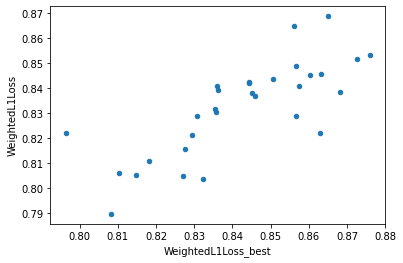

In [ ]:
# plot relationship between losses
results_df.plot.scatter('WeightedL1Loss_best', 'WeightedL1Loss')

### Duplicate functions

These functions have been copied here to avoid the importlib.reload shenanigans.

In [ ]:
def evaluate(model, loader, criterion, device, return_predictions=False):    
    epoch_loss = 0
    epoch_acc = 0
    model.eval()
    if return_predictions:
      list_predictions = []
    with torch.no_grad():
      for batch_idx, batch in enumerate(loader):
        if type(batch) is list:
          if len(batch) == 4:
            x1, len_x1, y, index = batch
          if len(batch) == 5:
            x1, len_x1, x2, y, index = batch
        else:
          x1, x2, len_x1, len_x2, y, index = (batch['X_b'],batch['X_t'],batch['b_len'],batch['t_len'],batch['y'],batch['ID'])

        if getattr(model,'uses_two_series_as_input',False) == True:
          predictions, _ = model(x1.to(device), len_x1.to(device), x2.to(device), len_x2.to(device))
        else:
          if isinstance(model,nn.modules.transformer.Transformer):
            # sz = x1.size(1)
            # src_mask = _generate_square_subsequent_mask(sz)
            x1 = x1.permute(1,0,2)
            x2 = x2.unsqueeze(0)
            predictions = model(x1.to(device), x2.to(device))
            predictions = predictions[:,:,0].transpose(0,1)
          else:  
            predictions, _ = model(x1.float().to(device), len_x1.to(device))

        #predictions = (predictions-.5)*2
        if return_predictions:
          list_predictions.append((predictions,y,index))

        if isinstance(predictions,tuple):
          predictions = predictions[0]

        loss = criterion(predictions.squeeze(1), y.to(device))
        epoch_loss += loss.item()

    if return_predictions:
      return epoch_loss / len(loader), list_predictions
    else:
      return epoch_loss / len(loader)


class EarlyStopping:
    """Early stops the training if validation loss doesn't improve after a given patience."""
    def __init__(self, patience=7, verbose=False, delta=0):
        """
        Args:
            patience (int): How long to wait after last time validation loss improved.
                            Default: 7
            verbose (bool): If True, prints a message for each validation loss improvement. 
                            Default: False
            delta (float): Minimum change in the monitored quantity to qualify as an improvement.
                            Default: 0
        """
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.val_loss_min = np.Inf
        self.delta = delta

    def __call__(self, val_loss, model):

        score = -val_loss

        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
        elif score < self.best_score + self.delta:
            self.counter += 1
            print(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
            self.counter = 0

    def save_checkpoint(self, val_loss, model):
        '''Saves model when validation loss decrease.'''
        if self.verbose:
            print(f'Validation loss decreased ({self.val_loss_min:.6f} --> {val_loss:.6f}).  Saving model ...')
        torch.save(model.state_dict(), 'checkpoint.pt')
        self.val_loss_min = val_loss

def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs


def train(model, loader, optimizer, criterion, device):
    epoch_loss = 0
    epoch_acc = 0
    model.train()
    for batch_idx, batch in enumerate(loader):
        if type(batch) is list:
          if len(batch) == 4:
            x1, len_x1, y, index = batch
            x1 = x1.float()
          if len(batch) == 5:
            x1, len_x1, x2, y, index = batch
        else:
          x1, x2, len_x1, len_x2, y, index = (batch['X_b'],batch['X_t'],batch['b_len'],batch['t_len'],batch['y'],batch['ID'])

        optimizer.zero_grad()
        if getattr(model,'uses_two_series_as_input',False) == True:
          predictions, _ = model(x1.to(device), len_x1.to(device), x2.to(device), len_x2.to(device))
        else:
          if isinstance(model,nn.modules.transformer.Transformer):
            # sz = x1.size(1)
            # src_mask = _generate_square_subsequent_mask(sz)
            x1 = x1.permute(1,0,2)
            x2 = x2.unsqueeze(0)
            predictions = model(x1.to(device), x2.to(device))
            predictions = predictions[:,:,0].transpose(0,1)
          else:  
            predictions, _ = model(x1.to(device), len_x1.to(device))

        if isinstance(predictions,tuple):
            predictions = predictions[0]

        loss = criterion(predictions.squeeze(1), y.to(device))
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
        
    return epoch_loss / len(loader)

def train_over_nepochs(model, train_loader, valid_loader, criterion, device, patience=20, n_epochs=5, best_valid_loss=float('inf'),
                       filename=None, use_tune=False):
  if use_tune:
    from ray import tune

  model = model.to(device)
  optimizer = optim.Adam(model.parameters())
  criterion = criterion.to(device)
  # initialize the early_stopping object
  epoch_time_list = []
  early_stopping = EarlyStopping(patience=patience, verbose=True)
  for epoch in range(n_epochs):
    train_iterator, valid_iterator = (iter(train_loader),iter(valid_loader))
    
    start_time = time.time()
    
    train_loss = train(model, train_iterator, optimizer, criterion, device)
    valid_loss = evaluate(model, valid_iterator, criterion, device)
        
    end_time = time.time()
        
    epoch_mins, epoch_secs = epoch_time(start_time, end_time)
    epoch_time_list.append(end_time-start_time)

    if use_tune:
      with tune.checkpoint_dir(epoch) as checkpoint_dir:
        path = os.path.join(checkpoint_dir, "checkpoint")
        torch.save((model.state_dict(), optimizer.state_dict()), path)
      tune.report(train_loss=train_loss,val_loss=val_loss)
    else:
      if valid_loss < best_valid_loss:
          best_valid_loss = valid_loss
          if filename is not None:
            torch.save(model.state_dict(), filename)

    if (epoch%2 == 0) or (epoch == n_epochs-1):    
      print(f'Epoch: {epoch+1:02} | Epoch Time: {epoch_mins}m {epoch_secs}s')
      print(f'\tTrain Loss: {train_loss:.3f}')
      print(f'\t Val. Loss: {valid_loss:.3f}')

    early_stopping(valid_loss, model)
    if early_stopping.early_stop:
      print("Early stopping")
      break

  # model.load_state_dict(torch.load('checkpoint.pt', map_location=lambda storage, loc: storage))

  return model, best_valid_loss, epoch_time_list

### Load the best model


In [ ]:
# load best model

RETRAIN = False
USE_LOSS_BEST = False
USE_BEST_VALIDATION = True
criterion = WeightedL1Loss(subreddit2weights['all'], BIN_WIDTH, MIN_VALUE)
#criterion = nn.MSELoss()
criterion_name = lambda x: x.__class__.__name__.split('.')[-1]


# see if the file with best params is available
# results_df = pd.read_pickle(results_filename)

if USE_LOSS_BEST:
  best_result = results_df.loc[results_df[criterion_name(criterion)+'_best'].argmin()]
else:
  best_result = results_df.loc[results_df[criterion_name(criterion)].argmin()]

# uncomment to load specific model instead
# best_result = results_df.iloc[0]
if RETRAIN:
    reset_seeds()
    model = models.GRUSentiment(best_result.params)
    _, valid_loss, _ = train_over_nepochs( model, train_loader, valid_loader,
                                        criterion=criterion, device=device,
                                        patience=3, n_epochs=N_EPOCHS)

    if USE_BEST_VALIDATION:
        model.load_state_dict(torch.load('checkpoint.pt', map_location=lambda storage, loc: storage))

else:
    model = models.GRUSentiment(best_result.params)
    if USE_BEST_VALIDATION:
        model.load_state_dict(best_result.para)
    else:
        model.load_state_dict(best_result.para_best)

model.to(device)

test_loss, outputs = evaluate(model, iter(test_loader), criterion=criterion, device=device, return_predictions=True)
model_yhat = outputs[0][0].cpu().numpy() # extract data from outputs
ilocs = outputs[0][2].cpu().numpy()
model_series = pd.Series(model_yhat.ravel(),index=ilocs)
del outputs

# print model params
print(best_result.params)
print(f'Test loss: {test_loss:.3f}')

{'input_size': 770, 'output_size': 1, 'uses_two_series_as_input': False, 'dropout_out': 0.0, 'hidden_size': 64, 'num_layers': 2, 'dropout_rnn': 0.0, 'bidirectional': False}
Test loss: 0.718


In [ ]:
tmp_df = get_baselines_df(test_loader)
tmp_df['model'] = model_series
tmp_df.head()

## **3.2** Training XGBoost Regressor as a baseline

In [28]:
from src.xgb_utils import weightedl1_obj, weightedl1_loss_sklearn, weightedl1_loss_xgb, plot_model_error, hyperParameterTuning_xgb, getKeysByValue, grid_search_xgb  

### XGB optimization

In [ ]:
GRIDS_MSE = False
GRIDS_L1 = False
if USE_XGB:
    if TRAIN:
        # LOADING DATA
        print("Loading data...")
        batch_train = next(iter(train_loader_xgb))
        batch_val   = next(iter(valid_loader_xgb))
        batch_test  = next(iter(test_loader_xgb))

        X_train,_,y_train,_ = batch_train
        X_val,  _,y_val,  _ = batch_val
        X_test, _,y_test, _ = batch_test

        # CONVERTING TO NUMPY ARRAYS
        X_train = X_train.to('cpu').numpy()
        y_train = y_train.to('cpu').numpy()
        X_val   = X_val.to('cpu').numpy()
        y_val   = y_val.to('cpu').numpy()
        X_test  = X_test.to('cpu').numpy()
        y_test  = y_test.to('cpu').numpy()   

        # DEFINING WEIGHTS
        bin_weights = subreddit2weights['all'].cpu().numpy()
        eval_set = [(X_train,y_train),(X_test,y_test),(X_val,y_val)]

        if GRID_SEARCH_XGB:
            param_tuning_xgb_l1 = {
                'learning_rate': [0.001,0.01, 0.1],
                'max_depth': [1, 3, 5],
                'min_child_weight': [1, 3, 5],
                'subsample': [0.5, 0.7],
                'colsample_bytree': [0.5, 0.7],
                'n_estimators' : [100, 200, 500],
                'objective': [weighted_l1_loss]
            }
            param_tuning_xgb_mse = {
                'learning_rate': [0.001,0.01, 0.1],
                'max_depth': [1, 3, 5],
                'min_child_weight': [1, 3, 5],
                'subsample': [0.5, 0.7],
                'colsample_bytree': [0.5, 0.7],
                'n_estimators' : [100, 200, 500],
                'objective': ['reg:squarederror']
            }
            if GRIDS_L1:
                print("Starting grid search...")
                best_parameters_l1 = hyperParameterTuning_xgb(
                    XGBRegressor(objective=weighted_l1_loss),
                    param_tuning_xgb_l1,X_train,y_train,X_val=X_val,y_val=y_val,
                    early_stop=3,eval_metric=WeightedL1Loss_calc)
                print(f"Best parameters for the L1 model found by grid search:{best_parameters_l1}") 
                best_para_xgb = open(MODELSDIR + "best_para_xgb_l1.pkl", "wb")
                pickle.dump(best_parameters_l1, best_para_xgb)
                best_para_xgb.close()    

                print("Fitting the model with WeightedL1Loss")
                xgb_model_l1 = XGBRegressor(**best_parameters_l1)
                xgb_model_l1.n_jobs = 4
                xgb_model_l1.fit(X_train,y_train,eval_set=eval_set,early_stopping_rounds=3,eval_metric = WeightedL1Loss_calc)
                
                print(f"Best ntree_limit for the L1 model:{xgb_model_l1.best_ntree_limit}")
                f = open(MODELSDIR + "best_ntree_l1.txt", "w")
                f.write(str(xgb_model_l1.best_ntree_limit))
                f.close()

                xgb_model_l1.save_model(MODELSDIR + "xgb_l1.model")    

                if PLOT_XGB:
                    #WL1 MODEL
                    plot_model_error(xgb_model_l1,'WeightedL1')   

                #EVAL
                print("Evaluating model...")
                test_criteria =[WeightedL1Loss( subreddit2weights['all'],BIN_WIDTH,MIN_VALUE),
                                nn.L1Loss(), nn.MSELoss()] 

                print("L1Loss Model test error:")
                for criterion in test_criteria:
                    test_error = criterion(torch.FloatTensor(xgb_model_l1.predict(X_test)).to(device),torch.FloatTensor(y_test).to(device))
                    print(criterion.__class__.__name__,test_error)   

            if GRIDS_MSE:

                print("Starting grid search...")
                best_parameters_mse = grid_search_xgb(early_stop=3,X_train=X_train,y_train=y_train,X_val=X_val,y_val=y_val,n_jobs=4)
                print(f"Best parameters for the MSE model found by grid search:{best_parameters_mse[0]}") 
                best_para_xgb = open(MODELSDIR + "best_para_xgb_mse.pkl", "wb")
                pickle.dump(best_parameters_mse, best_para_xgb)
                best_para_xgb.close()

                print("Fitting the model with MSE")
                xgb_model_mse = XGBRegressor(**best_parameters_mse)
                xgb_model_mse.n_jobs = 4

                xgb_model_mse.fit(X_train,y_train,eval_set=eval_set,early_stopping_rounds=3)
                print(f"Best ntree_limit for the MSE model:{xgb_model_mse.best_ntree_limit}")
                f = open(MODELSDIR + "best_ntree_mse.txt", "w")
                f.write(str(xgb_model_mse.best_ntree_limit))
                f.close()

                xgb_model_mse.save_model(MODELSDIR + "xgb_mse.model")    

                if PLOT_XGB:
                    #MSE MODEL
                    plot_model_error(xgb_model_mse,'rmse')      

                #EVAL
                print("Evaluating model...")
                test_criteria =[WeightedL1Loss( subreddit2weights['all'],BIN_WIDTH,MIN_VALUE),
                                nn.L1Loss(), nn.MSELoss()] 

                print("MSE Model test error:")
                for criterion in test_criteria:
                    test_error = criterion(torch.FloatTensor(xgb_model_mse.predict(X_test)).to(device),torch.FloatTensor(y_test).to(device))
                    print(criterion.__class__.__name__,test_error)
            
        else:
            print("Loading best parameters...")
            try:
                best_parameters_l1 = open(MODELSDIR + "best_para_xgb_l1.pkl", "rb")
                best_parameters_l1 = pickle.load(best_parameters_l1)
                print("Successfully loaded best parameters for the L1 model")
            except:
                print("L1 model parameters file not found, using standard ones instead")
                best_parameters_l1 = {
            'learning_rate': 0.1,
            'max_depth':  5,
            'min_child_weight': 3,
            'subsample': 0.5,
            'colsample_bytree': 0.5,
            'n_estimators' :  200,
            'objective': WeightedL1Loss_grad}

            try:
                best_parameters_mse = open(MODELSDIR + "best_para_xgb_mse.pkl", "rb")
                best_parameters_mse = pickle.load(best_parameters_mse)
                print("Successfully loaded best parameters for the MSE model")
            except:
                print("MSE model parameters file not found, using standard ones instead")
                best_parameters_mse = {
            'learning_rate': 0.1,
            'max_depth':  5,
            'min_child_weight': 3,
            'subsample': 0.5,
            'colsample_bytree': 0.5,
            'n_estimators' :  200,
            'objective': 'reg:squarederror'}            


            print("Fitting the model with WeightedL1Loss")
            xgb_model_l1 = XGBRegressor(**best_parameters_l1, n_jobs = 4)
            xgb_model_l1.fit(X_train,y_train,eval_set=eval_set,early_stopping_rounds=3)#,eval_metric = WeightedL1Loss_calc)

            print(f"Best ntree_limit for the model:{xgb_model_l1.best_ntree_limit}")
            f = open(MODELSDIR + "best_ntree_l1.txt", "w")
            f.write(str(xgb_model_l1.best_ntree_limit))
            f.close()

            xgb_model_l1.save_model(MODELSDIR + "xgb_l1.model")

            print("Fitting the model with MSE")
            xgb_model_mse = XGBRegressor(**best_parameters_mse, n_jobs=4)
            xgb_model_mse.fit(X_train,y_train,eval_set=eval_set,early_stopping_rounds=3)

            print(f"Best ntree_limit for the model:{xgb_model_mse.best_ntree_limit}")
            f = open(MODELSDIR + "best_ntree_mse.txt", "w")
            f.write(str(xgb_model_mse.best_ntree_limit))
            f.close()

            xgb_model_mse.save_model(MODELSDIR + "xgb_mse.model")     

            if PLOT_XGB:
                #WL1 MODEL
                plot_model_error(xgb_model_l1,'WeightedL1Loss') 

                #MSE MODEL
                plot_model_error(xgb_model_mse,'rmse')

            #EVAL
            print("Evaluating model...")
            print("-------------------------")
            test_criteria =[WeightedL1Loss( subreddit2weights['all'],BIN_WIDTH,MIN_VALUE),
                            nn.L1Loss(), nn.MSELoss()] 
                            
            print("MSE Model test error:")
            for criterion in test_criteria:
                test_error = criterion(torch.FloatTensor(xgb_model_mse.predict(X_test)).to(device),torch.FloatTensor(y_test).to(device))
                print(criterion.__class__.__name__,test_error)

            print("-------------------------")
            print("L1Loss Model test error:")
            for criterion in test_criteria:
                test_error = criterion(torch.FloatTensor(xgb_model_l1.predict(X_test)).to(device),torch.FloatTensor(y_test).to(device))
                print(criterion.__class__.__name__,test_error)


    if TEST:
        # LOADING DATA
        batch_test = next(iter(test_loader_xgb))
        X_test,_,y_test,_ = batch_test
        # CONVERTING TO NUMPY ARRAYS
        X_test = X_test.to('cpu').numpy()
        y_test = y_test.to('cpu').numpy() 
        
        #LOADING MODELS
        print("Loading trained xgb model...")
        xgb_model_l1 = XGBRegressor()
        xgb_model_mse = XGBRegressor()
        xgb_model_l1.load_model(MODELSDIR + "xgb_l1.model")
        xgb_model_mse.load_model(MODELSDIR + "xgb_mse.model")
        
        
        best_ntree_l1 = open(MODELSDIR + "best_ntree_l1.txt", "r")
        best_ntree_l1 = int(best_ntree_l1.read())
        best_ntree_mse = open(MODELSDIR + "best_ntree_mse.txt", "r")
        best_ntree_mse = int(best_ntree_mse.read())  

        print("Model and parameters loaded")
        print("-------------------------")

        #EVAL
        print("Evaluating model...")
        print("-------------------------")
        test_criteria =[WeightedL1Loss( subreddit2weights['all'],BIN_WIDTH,MIN_VALUE),
                        nn.L1Loss(), nn.MSELoss()] 
                        
        print("MSE Model test error:")
        for criterion in test_criteria:
            test_error = criterion(torch.FloatTensor(xgb_model_mse.predict(X_test)).to(device),torch.FloatTensor(y_test).to(device))
            print(criterion.__class__.__name__,test_error)

        print("-------------------------")
        print("L1Loss Model test error:")
        for criterion in test_criteria:
            test_error = criterion(torch.FloatTensor(xgb_model_l1.predict(X_test)).to(device),torch.FloatTensor(y_test).to(device))
            print(criterion.__class__.__name__,test_error)


## **4**. Comparing the results with simple baselines

In [ ]:
# TODO: add doc for this function
def compute_error(results_df, pred_column_name, criteria, device):
  return {criterion.__class__.__name__.split('.')[-1]:
          float(criterion(
              torch.Tensor(results_df[pred_column_name].values).to(device),
              torch.Tensor(results_df['final score'].values).to(device))
          ) for criterion in criteria}

In [ ]:
  # TODO: explain what this cell does
  pred_column_names = ['unchanged', 'mean','last']
  loss2title = {'L1Loss':'L1 Loss','MSELoss':'MSE Loss','WeightedL1Loss':'Weighted L1 Loss'}
  subreddit='all'

  criteria=[WeightedL1Loss(subreddit2weights[subreddit],BIN_WIDTH,MIN_VALUE)]
  criteria_names = [criterion.__class__.__name__.split('.')[-1] for criterion in criteria]

  test_loss = dict()
  for pred_column_name in pred_column_names:
    test_loss[pred_column_name] = compute_error(tmp_df, pred_column_name, criteria, device)

  df = pd.DataFrame.from_dict(test_loss,orient='index')
  df.columns = df.columns.map(loss2title)
  df.index = df.index.map(str.upper)
  df

,Weighted L1 Loss
LAST,0.841203
MEAN,0.808278
UNCHANGED,0.888190


In [ ]:
# fig, axs = plt.subplots(1,2, figsize=(6,3))
# for ax,y_col in zip(axs,['score_noavg','score']):
#   post_df.apply(lambda x: x[y_col][x.seq_len-1], axis=1).hist(ax=ax,bins=np.arange(.0,1.01,.05))
#   ax.set_title(y_col)
# plt.tight_layout()

In [ ]:
# TODO: it seems that this file is used as a way to consolidate RNN and XGB predictions. Can we organize this code to do this automatically?
# suggestion: most of the code in this notebook will go to either: (i) a .py containing functions shared by RNN and XGB; (ii) RNN-specific code; (iii) XGB-specific code
# the notebook then basically calls functions such as
# load_train_set()
# load_test_set()
# instantiate_data_loader(model)
# grid_search_<MODEL>(<LISTS OF HYPERPARAMETERS>) -> (HARD) ideally this should be the same function for both models
# load_best_<MODEL>
# <MODEL>.predict()
tmp_df = pd.read_csv(f'{RESULTSDIR}{PREFIX}_{SRC_DATASET}_predictions.csv',index_col=0)
tmp_df.head()


,unchanged,final score,thread ncom,mean,last,model,xgb-mse
10,-0.130042,-0.467600,2,0.012204,0.154450,0.341191,0.149213
17,0.523211,0.072975,5,0.216017,0.137519,0.533828,0.235764
20,0.058143,-0.100950,3,0.062931,0.130650,0.427484,0.199862
34,-0.126900,0.036950,5,-0.025573,0.036950,0.241738,0.080362
46,-0.142029,-0.274950,4,0.020388,-0.136600,0.383980,0.202052


### Generate results table

In [ ]:
# TODO: explain each of the cells below
subreddit2range2 = {}
for subreddit,v in subreddit2range.items():
  if type(v) == slice:
    inds = [ind for ind in tmp_df.index if v.start <= ind < v.stop]
  else:
    inds = list(tmp_df.index)
  subreddit2range2[subreddit] = inds
# subreddit2range2

pred_column_names = ['unchanged', 'mean','last','model']
loss2title = {'L1Loss':'L1 Loss','MSELoss':'MSE Loss','WeightedL1Loss':'Weighted L1 Loss'}

this


In [ ]:
subreddit2range

{'Anxiety': slice(0, 13533, None),
 'SuicideWatch': slice(86129, 101324, None),
 'all': array([     0,      1,      2, ..., 101321, 101322, 101323]),
 'bipolar': slice(13533, 23012, None),
 'depression': slice(23012, 86129, None)}

In [ ]:
subreddit2range2['bipolar']

[13544,
 13547,
 13550,
 13556,
 13565,
 13583,
 13598,
 13605,
 13612,
 13616,
 13621,
 13643,
 13653,
 13661,
 13664,
 13669,
 13686,
 13717,
 13722,
 13732,
 13744,
 13764,
 13770,
 13776,
 13783,
 13786,
 13788,
 13789,
 13814,
 13843,
 13845,
 13848,
 13852,
 13855,
 13858,
 13859,
 13863,
 13864,
 13872,
 13874,
 13878,
 13887,
 13897,
 13899,
 13913,
 13930,
 13954,
 13964,
 13973,
 13977,
 13980,
 13986,
 13988,
 13999,
 14001,
 14004,
 14012,
 14016,
 14017,
 14024,
 14025,
 14026,
 14030,
 14060,
 14073,
 14076,
 14113,
 14127,
 14130,
 14131,
 14149,
 14157,
 14166,
 14177,
 14182,
 14183,
 14185,
 14190,
 14208,
 14209,
 14226,
 14240,
 14300,
 14320,
 14339,
 14342,
 14355,
 14360,
 14367,
 14380,
 14385,
 14391,
 14392,
 14394,
 14404,
 14409,
 14410,
 14413,
 14414,
 14424,
 14435,
 14437,
 14454,
 14456,
 14458,
 14463,
 14469,
 14470,
 14477,
 14519,
 14535,
 14550,
 14601,
 14611,
 14612,
 14614,
 14618,
 14625,
 14629,
 14651,
 14671,
 14689,
 14696,
 14703,
 14717,


In [ ]:
# tmp_df['model'] = model_yhat
# tmp_df['xgboost'] = xgb_model_l1.predict(X_test)
# tmp_df['xgb-mse'] = xgb_model_mse.predict(X_test)


df_list = []
for subreddit in ['all']+SUBREDDITS:
  criteria=[WeightedL1Loss(subreddit2weights[subreddit],BIN_WIDTH,MIN_VALUE)]
  #criteria=[nn.L1Loss(),nn.MSELoss()]
  criteria_names = [criterion.__class__.__name__.split('.')[-1] for criterion in criteria]

  test_loss = dict()
  for pred_column_name in pred_column_names:
    test_loss[pred_column_name] = compute_error(tmp_df.loc[subreddit2range2[subreddit]], pred_column_name, criteria, device)

  df = pd.DataFrame.from_dict(test_loss,orient='index')
  df.columns = df.columns.map(loss2title)
  df.index = df.index.map(str.upper)
  df_list.append(df)

test_df = pd.concat(df_list,keys=['ALL']+[subreddit2title[subreddit.lower()] for subreddit in SUBREDDITS],axis=1)
test_df = test_df.swaplevel(0,1,axis=1).sort_index(1)
n=len(SUBREDDITS)+1
test_df = test_df.round(3)
test_df = test_df.loc[['UNCHANGED','MEAN','LAST','MODEL'],:]
test_df

In [ ]:
formatters = []
for column in test_df.columns:
  formatters.append(lambda x, column=column: '\\textbf{%s}'%( ('%.3f' % float(x)).lstrip('0') ) if float(x) == test_df[column].min() else ('%.3f'% float(x)).lstrip('0') )
formatters

[<function __main__.<lambda>>, <function __main__.<lambda>>]

In [ ]:
print(test_df.to_latex(
    escape=False,column_format='l|ccccc|ccccc|ccccc',multicolumn_format='c',
    label='tab:test_loss', formatters=formatters,
    caption='Results w.r.t.\\ L1, MSE and proposed Weighted L1 Loss, which gives more weight to more extreme responses. '+
    'Model is trained on entire 2017 dataset whereas \\textsc{Model-Subreddit} is trained on target subreddit (column). '+
    '\\textsc{Mean} yields lowest L1 and MSE, but Model outperforms baselines w.r.t.\\ Weighted L1 loss.'
    ))

\begin{table}
\centering
\caption{Results w.r.t.\ L1, MSE and proposed Weighted L1 Loss, which gives more weight to more extreme responses. Model is trained on entire 2017 dataset whereas \textsc{Model-Subreddit} is trained on target subreddit (column). \textsc{Mean} yields lowest L1 and MSE, but Model outperforms baselines w.r.t.\ Weighted L1 loss.}
\label{tab:test_loss}
\begin{tabular}{l|ccccc|ccccc|ccccc}
\toprule
{} & \multicolumn{2}{c}{Weighted L1 Loss} \\
{} &              ALL &           WTT \\
\midrule
UNCHANGED &             .974 &          .974 \\
MEAN      &             .956 &          .956 \\
LAST      &    \textbf{.877} & \textbf{.877} \\
MODEL     &            1.013 &         1.013 \\
\bottomrule
\end{tabular}
\end{table}



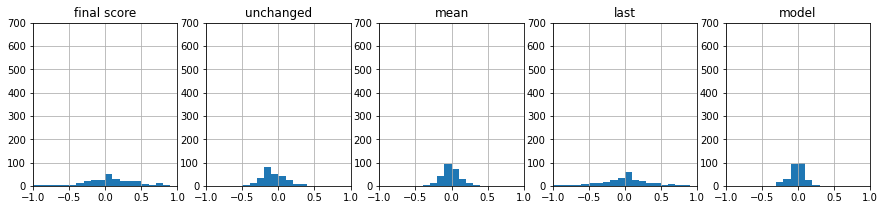

In [ ]:
pred_column_names2 = ['final score']+pred_column_names
fig, axs = plt.subplots(1,len(pred_column_names2), figsize=(3*len(pred_column_names2),3))
for ax, column_name in zip(axs,pred_column_names2):
  ax = tmp_df[column_name].hist(ax=ax,bins=np.arange(-1.0,1.0,.1))
  ax.set_xlim(-1,1)
  ax.set_ylim(0,700)
  ax.set_title(column_name)

In [ ]:
# pred_column_names = ['unchanged', 'mean','last','model']

# for subreddit in SUBREDDITS:
#   print(subreddit)

#   criteria=[nn.L1Loss(),nn.MSELoss(),WeightedL1Loss(subreddit2weights[subreddit],,BIN_WIDTH)]
#   criteria_names = [criterion.__class__.__name__.split('.')[-1] for criterion in criteria]

#   test_loss = dict()
#   for pred_column_name in pred_column_names:
#     test_loss[pred_column_name] = compute_error(tmp_df.loc[subreddit2range[subreddit]], pred_column_name, criteria, device)
#   test_df = pd.DataFrame.from_dict(test_loss, orient='index').round(3)
  
#   print(test_df)

In [ ]:
# prob=bin_weights[np.floor(tmp_df['final score'].values/BIN_WIDTH).astype(int)].numpy()
# prob=prob/prob.sum()

In [ ]:
# nz = np.nonzero((tmp_df['thread ncom']<64).values)
# nz[0].shape

# **5**. Plotting the results

In [ ]:
# remove "initial score" baseline
# from mpl_toolkits.axes_grid1 import make_axes_locatable # TODO: REMOVE ALL COMMENTED CODE?

# TODO: add doc to function
def plot_prediction_density(tmp_df, pred_column_names, subreddit=None, axs=None, choice_inds=None, cmap=plt.cm.gist_earth_r, vmax=None):
  if subreddit is not None:
    tmp_df = tmp_df.loc[subreddit2range[subreddit]]

  xmin = ymin = -1.
  xmax = ymax =  1.

  # deltaX = (max(x) - min(x))/10
  # deltaY = (max(y) - min(y))/10
  # xmin = min(x) - deltaX
  # xmax = max(x) + deltaX
  # ymin = min(y) - deltaY
  # ymax = max(y) + deltaY
  # xx, yy = np.mgrid[xmin:xmax:50j, ymin:ymax:50j]

  xx, yy = np.mgrid[xmin:xmax:50j, ymin:ymax:50j]
  positions = np.vstack([xx.ravel(), yy.ravel()])
  reset_seeds()

  if choice_inds is None:
    choice_inds = np.random.choice(len(tmp_df), 100)
  print(tmp_df.iloc[choice_inds]['thread ncom'].max())
  # choice_inds = np.random.choice(nz[0], 100)

  if axs is None:
   fig, axs = plt.subplots(2,2,figsize=(3*2,3*2),sharex=True,sharey=True)
   plt.subplots_adjust(wspace=.15,hspace=.15)

  for idx, (ax, column_name) in enumerate(zip(axs.ravel(),pred_column_names)):
    loss_array = tmp_df[['final score', column_name]].values
    kernel = stats.gaussian_kde(loss_array.T)
    Z = np.reshape(kernel(positions).T, xx.shape)
    # print(subreddit,idx,Z.min(),Z.max())

    if vmax is not None:
      levels = np.linspace(vmax/8.,vmax,8)
      # levels = np.insert(np.linspace(vmax*2/7.,vmax,7),0,0)
      vmin=vmax/8.
    else:
      levels = 8
      vmin=None

    ax.plot([xmin, xmax], [ymin, ymax], ls='-', c='k',alpha=.5)#,transform=ax.transAxes)

    # cfset = ax.contourf(xx, yy, Z, cmap=cmap, levels=levels)
    hb = ax.imshow(np.rot90(Z), cmap=cmap, aspect='auto',
              extent=[xmin, xmax, ymin, ymax], vmin=0,vmax=vmax)
    # cset = ax.contour(xx, yy, Z, colors='k', linewidths=.25, levels=levels)
    # plt.colorbar(hb, ax=ax)
    # ax.clabel(cset, inline=1, fontsize=8)


    ncom = tmp_df['branch ncom'].values if column_name.startswith('branch') else tmp_df['thread ncom'].values
    ax.scatter(loss_array[choice_inds,0], loss_array[choice_inds,1], 2*ncom[choice_inds], 'gray', edgecolor='k')

    ax.set_xlim([xmin, xmax])
    ax.set_ylim([ymin, ymax])
    # ax.yaxis.tick_right()
    # ax.set_xticks(np.arange(-1.,1.,.5))
    ax.set_yticks(np.arange(-1.,1.01,.5))
    ax.grid(ls='--', c='gray', alpha=.5)

    # ax.axhline((ymin+ymax)/2,color='k',alpha=.5)
    # ax.axvline((xmin+xmax)/2,color='k',alpha=.5)
    # x = np.array([xmin,xmax])
    # ax.plot(x, 1.5*x, ls='--', c='k',alpha=.5)
    # ax.plot(x, 0.5*x, ls='--', c='k',alpha=.5)
    # ax.set_title(column_name)


  # divider = make_axes_locatable(plt.gca())
  # cax = divider.append_axes("right", size="2%", pad=0.00)
  # cbar = fig.colorbar(hb, cax=cax)

  # fig.text(0.5, 0.04, r'EmT($c_n$) (true value)', ha='center')
  # fig.text(0.04, 0.5, 'prediction', va='center', rotation='vertical')

  # plt.savefig(RESULTSDIR+subreddit+'.pdf')
  return hb

In [ ]:
tmp_df

,unchanged,final score,thread ncom,mean,last,model,xgb-mse,xgb
10,-0.130042,-0.467600,2,0.090412,0.154450,0.341191,0.177147,0.177147
17,0.523211,0.072975,5,0.504602,0.137519,0.533828,0.526253,0.526253
20,0.058143,-0.100950,3,0.193499,0.130650,0.427484,0.381440,0.381440
34,-0.126900,0.036950,5,0.013639,0.036950,0.241738,-0.100567,-0.100567
46,-0.142029,-0.274950,4,0.107043,-0.136600,0.383980,0.390274,0.390274
...,...,...,...,...,...,...,...,...
63083,0.088600,-0.076933,6,0.078371,-0.294600,-0.222280,-0.129750,-0.129750
63093,0.154550,0.000000,8,0.041031,-0.002800,-0.477948,-0.540553,-0.540553
63099,-0.190156,0.560600,3,0.374593,0.185833,-0.041443,0.199567,0.199567
63102,-0.275480,-0.284600,5,0.211514,0.202300,-0.512492,0.055188,0.055188


In [ ]:
pred_column_names = ['mean', 'xgb']

34
64
46
58


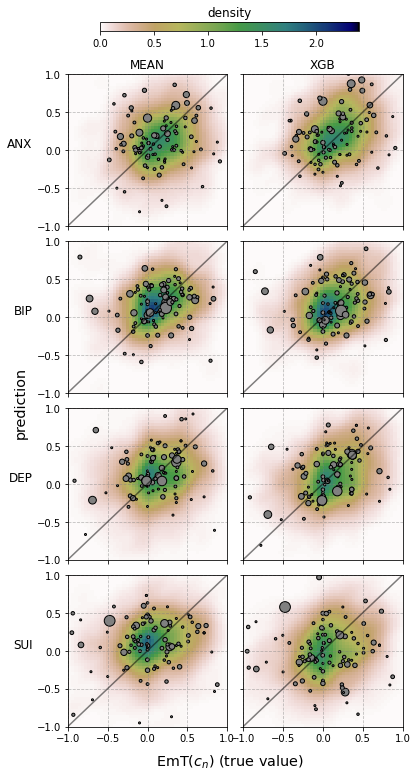

In [ ]:
# plot density
vmax_list = [2, 3.2, 2., 2.]
vmax_list = [2.4, 2.4, 2.4, 2.4]

choice_inds = None

fig, axs = plt.subplots(4,4,figsize=(3*4,3*4),sharex=True,sharey=True)
plt.subplots_adjust(wspace=.1,hspace=.1)

for ix, subreddit in enumerate(SUBREDDITS):
  hb = plot_prediction_density(tmp_df, pred_column_names[1:], subreddit, axs[ix,:], choice_inds=choice_inds, vmax=vmax_list[ix])

fig.text(0.5 , 0.08, r'EmT($c_n$) (true value)', ha='center', fontsize='x-large')
fig.text(0.0, 0.5 , 'prediction', va='center', rotation='vertical', fontsize='x-large')

cbaxes = fig.add_axes([0.2, 0.93, .6, 0.01])

for ax, col in zip(axs[0], pred_column_names[1:]):
  ax.set_title(col.upper(), size='large')

for ax, row in zip(axs[:,0], SUBREDDITS):
  # ax.yaxis.set_label_position("right")
  ax.set_ylabel(subreddit2title[row.lower()], rotation=0, size='large', horizontalalignment='right')

cb = plt.colorbar(hb, cax = cbaxes, orientation='horizontal')
cb.ax.set_title('density', size='large')
plt.savefig('heatmaps.pdf')

# fig.colorbar(hb, ax=axs,location='bottom', shrink=.5)
# plt.tight_layout()

# divider = make_axes_locatable(plt.gca())
# cax = divider.append_axes("right", size="2%", pad=0.00)
# cbar = fig.colorbar(hb, cax=cax)


# **6**. Case Study

In [ ]:
# TODO: explain what we are reading
REDDIT='SuicideWatch'
suffix = '.p'
with open(DATADIR+REDDIT+'_post2data'+suffix,'rb') as infile:
  post2data = pickle.load(infile)

with open(DATADIR+REDDIT+'_comment2data'+suffix,'rb') as infile:
  comment2data = pickle.load(infile)

In [ ]:
# 58762
z = tmp_df.loc[subreddit2range2['SuicideWatch']]
z[(z['final score'] > 0.75) & (z['model'] < -0.75)].sort_values('final score',ascending=True).head(20)

,unchanged,final score,thread ncom,mean,last,model,xgb-mse
58762,-0.8004,0.875,7,-0.252438,-0.1761,-0.924048,0.020039


In [ ]:
# 40001
z = tmp_df.loc[subreddit2range2['Anxiety']]
z[(z['final score'] > 0.75) & (z['model'] > 0.6)].sort_values('thread ncom',ascending=True).head(20)

,unchanged,final score,thread ncom,mean,last,model,xgb-mse
4001,-0.064500,0.87575,2,0.019070,0.102640,0.738646,0.214676
6195,-0.069314,0.84765,2,0.074051,0.217417,0.670065,0.344125
11413,0.077006,0.86020,2,0.229403,0.381800,0.675269,0.274277
6468,-0.881900,0.76500,3,-0.291783,-0.116650,0.881442,0.075356
4296,0.238200,0.91360,4,0.132615,-0.050111,0.667807,0.249140
6265,-0.189891,0.84810,4,-0.007503,0.075833,0.623283,0.187164
1095,-0.081675,0.97360,6,0.301792,0.784500,0.759454,0.303918
4046,0.080025,0.87200,8,0.133222,0.678867,0.771944,0.220229
11193,0.067716,0.91180,10,0.356118,0.063900,0.685611,0.344369
10024,-0.251600,0.90420,13,0.094388,0.119744,0.701972,0.189217


In [ ]:
# TODO: remove for in all cells below, just set ind to each value
for ind in [58762]:
  print(post_df.iloc[ind])
  print(tmp_df.loc[ind])
  print_post_and_comments(ind)

author                                                   CPisJamesC
created_utc       [2017-09-19 11:35:57, 2017-09-19 11:46:25, 201...
text              Today my supervisor told me my last day at wor...
title                          Today I found out I'd be laid off...
comments          [dn7klsg, dn7ktef, dn7kvmi, dn7l1zb, dn8cpw1, ...
score             [-0.8004, -0.1909, 0.25, 0.07773333333333333, ...
parent_id         [712ctw, dn7klsg, 712ctw, dn7kvmi, 712ctw, dn8...
is_post_author    [True, False, True, False, True, False, True, ...
features          [[tensor(0.0878), tensor(0.2792), tensor(0.061...
seq_len                                                           8
Name: (SuicideWatch, 712ctw), dtype: object
unchanged     -0.800400
final score    0.875000
thread ncom    7.000000
mean          -0.252438
last          -0.176100
model         -0.924048
xgb-mse        0.020039
Name: 58762, dtype: float64
Post id: 712ctw
Author (score -2.6008):
('Today my supervisor told me my last da

In [ ]:
# 13443
z = tmp_df.loc[subreddit2range2['bipolar']]
z[(z['final score'] < -0.75) & (z['model'] < 0.1) & (z['model'] > 0)].sort_values('thread ncom',ascending=False).head(20)

,unchanged,final score,thread ncom,mean,last,model,xgb-mse
13443,-0.11470,-0.8481,8,0.355956,0.63690,0.012588,0.253376
17101,-0.17295,-0.7501,3,-0.078944,0.18315,0.053429,0.128533


In [ ]:
# 14183
z[(z['final score'] > -0.5) & (z['model'] < -0.5)].sort_values('thread ncom',ascending=False).head(20)

In [ ]:
# 50549
z = tmp_df.loc[subreddit2range2['SuicideWatch']]
z[(z['final score'] > .6) & (z['final score'] < .75)  & (z['model'] > .6) & (z['model'] < .75)].sort_values('thread ncom',ascending=False)


,unchanged,final score,thread ncom,mean,last,model,xgb-mse
62296,0.182973,0.6952,36,0.138060,0.335200,0.720109,0.108002
50549,0.078227,0.7345,9,0.130760,0.044433,0.688784,0.234148
53131,0.059129,0.6990,8,0.196700,-0.065364,0.621237,0.234585
58800,-0.144948,0.7096,4,0.233559,0.542340,0.719088,0.323608


In [ ]:
for ind in [50549]:
  print(post_df.iloc[ind])
  print(tmp_df.loc[ind])
  print_post_and_comments(ind)

author                                                  MainlyMax97
created_utc       [2017-01-13 15:36:22, 2017-01-13 16:11:41, 201...
text              So here's my story... There is a little backgr...
title                                             LGBT mentally ill
comments          [dcdoywz, dcdpebc, dcdrv91, dcdrypd, dcdsat3, ...
score             [0.07822692307692306, -0.033574999999999994, 0...
parent_id         [5nr93y, 5nr93y, dcdoywz, dcdpebc, dcdrypd, dc...
is_post_author    [True, False, False, True, False, False, False...
features          [[tensor(0.0893), tensor(-0.2627), tensor(-0.0...
seq_len                                                          10
Name: (SuicideWatch, 5nr93y), dtype: object
unchanged      0.078227
final score    0.734500
thread ncom    9.000000
mean           0.130760
last           0.044433
model          0.688784
xgb-mse        0.234148
Name: 50549, dtype: float64
Post id: 5nr93y
Author (score -0.843546153846154):
("So here's my story... There

In [ ]:
for ind in [13443]:
  print(post_df.iloc[ind])
  print(tmp_df.loc[ind])
  print_post_and_comments(ind)
  print('------------------------------------------------------')

author                                                CosmicFallacy
created_utc       [2017-03-02 06:04:53, 2017-03-02 10:53:50, 201...
text              It is irritating me so much how I am not movin...
title             Do you feel like you aren't able to move as fa...
comments          [deepur5, deeq6xp, def2sk2, defcqc4, defekvp, ...
score             [-0.1147, 0.1939, 0.49095, 0.1691, 0.9196, 0.2...
parent_id         [5x1ll5, 5x1ll5, deepur5, 5x1ll5, 5x1ll5, 5x1l...
is_post_author    [True, False, False, True, False, False, False...
features          [[tensor(-0.0108), tensor(0.1373), tensor(0.00...
seq_len                                                           9
Name: (bipolar, 5x1ll5), dtype: object
unchanged     -0.114700
final score   -0.848100
thread ncom    8.000000
mean           0.355956
last           0.636900
model          0.012588
xgb-mse        0.253376
Name: 13443, dtype: float64
Post id: 5x1ll5
Author (score -1.2294):
('It is irritating me so much how I am not mo

In [ ]:
# loader  = DataLoader(Subset(dataset, [4834,4835]), batch_size=2, shuffle=False, num_workers=1)
# test_loss, outputs = evaluate(model, iter(loader), criterion=criterion, device=device, return_predictions=True)
# model_yhat = outputs[0][0].cpu().numpy() # extract data from outputs
# ilocs = outputs[0][2].cpu().numpy()
# model_series = pd.Series(model_yhat.ravel(),index=ilocs)
# model_series

In [ ]:
# print sample results
tmp_df.loc[47832].drop(columns=['thread ncom'])

unchanged     -0.141150
final score    0.421300
thread ncom    5.000000
mean           0.307873
last           0.605850
model          0.509338
Name: 47832, dtype: float64

In [ ]:
# (depression, 7im4c6)
post_df.iloc[47832]
tmp_df.loc[47832]
#print_post_and_comments(47832)

author                                                   katnam1510
created_utc       [2017-12-09 10:40:13, 2017-12-09 10:47:47, 201...
text              Can somebody drag me out of this depression? S...
title                                                I’m dying here
comments          [dqzqhb4, dqzqjf4, dqzqkie, dqzqmx1, dqzqoz4, ...
score             [-0.14115, 0.7717, 0.3659666666666667, -0.063,...
parent_id         [7im4c6, dqzqhb4, dqzqjf4, 7im4c6, dqzqmx1, 7i...
is_post_author       [True, False, True, False, False, True, False]
features          [[tensor(0.2144), tensor(0.0317), tensor(-0.13...
seq_len                                                           6
Name: (depression, 7im4c6), dtype: object

In [ ]:
# (bipolar, 5ukczo)
print(post_df.iloc[13149])
tmp_df.loc[13149]
#print_post_and_comments(13149)

author                                                   CecilOtter
created_utc       [2017-02-17 05:01:07, 2017-02-17 05:06:36, 201...
text              It seems like everyone I meet with Bipolar Dis...
title                                  How many of you are artists?
comments          [dduow1c, ddupc6v, dduph1o, dduq74e, dduqn6r, ...
score             [0.21423333333333336, 0.296, 0.5975, 0.0983999...
parent_id         [5ukczo, 5ukczo, 5ukczo, 5ukczo, 5ukczo, 5ukcz...
is_post_author    [True, False, False, False, False, False, Fals...
features          [[tensor(0.1116), tensor(0.0271), tensor(-0.18...
seq_len                                                          35
Name: (bipolar, 5ukczo), dtype: object


unchanged       0.214233
final score     0.570050
thread ncom    34.000000
mean            0.181779
last            0.000000
model           0.278749
Name: 13149, dtype: float64

In [ ]:
def print_post_and_comments(index, suffix='', infile_extension='.p'):
  post = post_df.iloc[index]

  print(f'Post id: {post.name[1]}')
  print(f'Author (score {(post["score"][0]-0.5)*2}):')

  subreddit = post.name[0]
  with open(f'{DATADIR}{subreddit}_comment2data{suffix}{infile_extension}','rb') as infile:
    comment2data = pickle.load(infile)

  comment_ids = post.comments
  pprint.pprint(post.text)
  for cx in range(max(0,post.seq_len-10),post.seq_len-1):
    print('Author' if post.is_post_author[cx+1] else 'Commenter', end='')
    print(f' (score {(post["score"][cx+1])}):')
    if 'body' in comment2data[comment_ids[cx]]:
      pprint.pprint(comment2data[comment_ids[cx]]['body'])
    else:
      pprint.pprint(comment2data[comment_ids[cx]]['text'])

In [ ]:
post_df.index.get_loc(('depression', '7im4c6'))

47832

In [ ]:
print_post_and_comments(4834)

Post id: 6fwwqe
Author (score -1.3827333333333334):
("I really hate this. So today I got my crush's snapchat, and I was really "
 'happy about that. So I get home and snapchat her, and I guess I really am '
 'fucked up. Anytime she responds to me I start getting really nervous, I '
 "don't know what to reply with and I'm afraid I'm gonna mess up my responses "
 'to the point where it hurts my chest and makes me feel like puking, and I '
 'overthink every response I get and its all fucking me up, I wish I could '
 'just be normal and do this kind of shit. I rely on relationships/love etc. '
 "for my happiness so I can't just not do this, I'm not sure what to do.")
Commenter (score -0.7827714285714286):
('Hey dude, I just got out of a 4 year relationship and I get that feeling of '
 'needing a relationship to be happy. Its kind of scary being alone but you '
 'know what you want. When my crush snapchats me I get the same way. I wait a '
 "few minutes before answering because I'm scared. 

In [ ]:
# adicionei este erro de propósito para que o "Run All" pare de executar aqui
print_post_and_comments(1293918201273)

IndexError: ignored

In [ ]:
# print_post_and_comments(1846, '_after_Dec2019', '.pkl')

In [ ]:
# print_post_and_comments(4917, '_after_Dec2019', '.pkl')

In [ ]:
# print_post_and_comments(6201, '_after_Dec2019', '.pkl')

In [ ]:
# print_post_and_comments(10881, '_after_Dec2019', '.pkl')

#**7**. Can we predict large fluctuations from one author comment to the next?

1. Plot the distribution of changes from one comment to the next.
2. Take the largest fluctuations and see how well we predict those. Is this large or small? Are the baselines predicting those better?
3. For those that we do well, inspect content of the post, "last checkpoint of author", following comment and last comment of author.

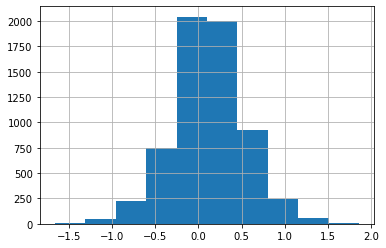

In [ ]:
#TODO: alternate the cells with the descriptions 1,2,3 above
fluctuations = []


for batch in test_loader:
  is_author_value = batch[0][0][0,-1] # this has to be retrieved because the feature was z-normalized
  batch_size = batch[0].size(0)

for ix in range(batch_size):
    ncom = batch[1][ix]
    for jx in range(ncom-1,-1,-1):
      if batch[0][ix][jx,-1] == is_author_value:
          fluctuations.append(batch[2][ix]-(batch[0][ix][jx,-2]*score_s+score_m))
          break   

fluctuations = np.array(fluctuations)
# fluctuation_series = pd.Series(fluctuations, index=test_locs)
fluctuation_series = pd.Series(fluctuations)
fluctuation_series.hist()

In [ ]:
fluctuation_series = tmp_df['final score']-tmp_df['unchanged']
fluctuation_series.head()

10   -0.337558
17   -0.450236
20   -0.159093
34    0.163850
46   -0.132921
dtype: float64

In [ ]:
# positive variation



def get_error_stats(series, lower_bound=None,upper_bound=None):
  assert (lower_bound is not None) ^ (upper_bound is not None)
  if upper_bound is not None:
    selected_inds = series[series < upper_bound].index
    print(f'[Upper bound: {upper_bound:.3f}] ',sep='')
  if lower_bound is not None:
    selected_inds = series[series > lower_bound].index
    print(f'[Lower bound: {lower_bound:.3f}] ',sep='')

  sub_df = tmp_df.loc[selected_inds]

  model_error = (sub_df['final score']-sub_df['model']).abs()
  results = {'MODEL L1':model_error.mean()}
  for baseline in ['mean','last','xgb']:
    baseline_error = (sub_df['final score']-sub_df[baseline]).abs()
    succ_fraction = (model_error < baseline_error).mean()
    print( f"Model outperforms {baseline} in {succ_fraction*100:.1f}% of all cases")
    print( f"Model error: {model_error.mean():.3f}\t Baseline error: {baseline_error.mean():.3f}")
    results[baseline] = {f'M outp. {baseline.upper()} (%)': succ_fraction,
                         f'{baseline.upper()} L1': baseline_error.mean() }

  print(f"Cases: {len(selected_inds)}\n\n")
  return results

n=len(fluctuation_series)
upper_bound=fluctuation_series.sort_values().iloc[int(0.05*n)]
lower_bound=fluctuation_series.sort_values().iloc[int(0.95*n)]

extreme_stats = {}

print('XXXX Fluctuation from previous comment: <5-th and >95-th percentile')
extreme_stats['EmT shift $>$ 95th perc.'] = get_error_stats(fluctuation_series, lower_bound=lower_bound)
extreme_stats['EmT shift $>$ +1.0'] = get_error_stats(fluctuation_series, lower_bound=1.)
extreme_stats['Final EmT $>$ +0.8'] = get_error_stats(tmp_df['final score'], lower_bound=.8)

extreme_stats['EmT shift $<$  5th perc.'] = get_error_stats(fluctuation_series, upper_bound=upper_bound)
extreme_stats['EmT shift $<$ -1.0'] = get_error_stats(fluctuation_series, upper_bound=-1.)
extreme_stats['Final EmT $<$ -0.8'] = get_error_stats(tmp_df['final score'], upper_bound=-.8)

print('XXX Fluctuation from previous comment: <-0.5 and >0.5')

print('XXX Final score: <0.1 and >0.9')


XXXX Fluctuation from previous comment: <5-th and >95-th percentile
[Lower bound: 0.867] 
Model outperforms mean in 71.1% of all cases
Model error: 0.522	 Baseline error: 0.676
Model outperforms last in 50.8% of all cases
Model error: 0.522	 Baseline error: 0.521
Model outperforms xgb-mse in 51.4% of all cases
Model error: 0.522	 Baseline error: 0.499
Cases: 315


[Lower bound: 1.000] 
Model outperforms mean in 68.7% of all cases
Model error: 0.583	 Baseline error: 0.743
Model outperforms last in 46.4% of all cases
Model error: 0.583	 Baseline error: 0.544
Model outperforms xgb-mse in 48.8% of all cases
Model error: 0.583	 Baseline error: 0.536
Cases: 166


[Lower bound: 0.800] 
Model outperforms mean in 89.1% of all cases
Model error: 0.469	 Baseline error: 0.788
Model outperforms last in 73.1% of all cases
Model error: 0.469	 Baseline error: 0.668
Model outperforms xgb-mse in 78.2% of all cases
Model error: 0.469	 Baseline error: 0.685
Cases: 119


[Upper bound: -0.434] 
Model outper

In [ ]:
extreme_df = pd.DataFrame.from_dict(extreme_stats, orient='index')
extreme_df = pd.concat((extreme_df,extreme_df['mean'].apply(pd.Series),extreme_df['last'].apply(pd.Series),extreme_df['xgb'].apply(pd.Series)), axis=1).drop(columns=['last','mean','xgb'])
#extreme_df[['MEAN L1','MODEL L1','LAST L1','XGB L1']] = extreme_df[['MEAN L1','MODEL L1','LAST L1']].multiply(2)
extreme_df = extreme_df.round(3)
extreme_df['M outp. MEAN (%)'] = extreme_df['M outp. MEAN (%)']*100
extreme_df['M outp. LAST (%)'] = extreme_df['M outp. LAST (%)']*100
extreme_df['M outp. XGB (%)'] = extreme_df['M outp. XGB (%)']*100

new_columns = [extreme_df.columns[ix] for ix in [0,2,4,6,1,3,5]] 
extreme_df = extreme_df[new_columns]
extreme_df

,MODEL L1,MEAN L1,LAST L1,XGB-MSE L1,M outp. MEAN (%),M outp. LAST (%),M outp. XGB-MSE (%)
EmT shift $>$ 95th perc.,0.522,0.676,0.521,0.499,71.1,50.8,51.4
EmT shift $>$ +1.0,0.583,0.743,0.544,0.536,68.7,46.4,48.8
Final EmT $>$ +0.8,0.469,0.788,0.668,0.685,89.1,73.1,78.2
EmT shift $<$ 5th perc.,0.426,0.558,0.563,0.610,61.3,60.6,65.4
EmT shift $<$ -1.0,0.440,0.835,0.806,0.825,84.6,76.9,84.6
Final EmT $<$ -0.8,0.403,0.819,0.887,0.956,88.9,88.9,93.3


In [ ]:
formatters = []
for ix, column in enumerate(extreme_df.columns):
  formatters.append(lambda x, column_ix=ix: '\\textbf{%s}'%( ('%.1f' % float(x)).lstrip('0') ) if (column_ix >=3 and x > 50) else ('%.3f'% float(x)).lstrip('0') )
formatters

[<function __main__.<lambda>>,
 <function __main__.<lambda>>,
 <function __main__.<lambda>>,
 <function __main__.<lambda>>,
 <function __main__.<lambda>>,
 <function __main__.<lambda>>,
 <function __main__.<lambda>>]

In [ ]:
print(extreme_df.to_latex(
    column_format='l|rrrr|ccc',  escape=False, label='tab:extreme_values', formatters=formatters,
    caption='Performance on extreme values. Central columns show L1 error for \\textsc{Mean}, \\textsc{Model} and \\textsc{Last}. '+
    'First (last) column show fraction of cases (selected from test set according to row description) where \\textsc{Model} outperforms '+
    '\\textsc{Mean} (\\textsc{Last}). For extremely positive shifts, \\textsc{Last} performs best because a large improvement is often '+
    'preceded by a very positive comment. For extremely negative shifts, \\textsc{Model} performs best.'))

\begin{table}
\centering
\caption{Performance on extreme values. Central columns show L1 error for \textsc{Mean}, \textsc{Model} and \textsc{Last}. First (last) column show fraction of cases (selected from test set according to row description) where \textsc{Model} outperforms \textsc{Mean} (\textsc{Last}). For extremely positive shifts, \textsc{Last} performs best because a large improvement is often preceded by a very positive comment. For extremely negative shifts, \textsc{Model} performs best.}
\label{tab:extreme_values}
\begin{tabular}{l|rrrr|ccc}
\toprule
{} & MODEL L1 & MEAN L1 & LAST L1 & XGB-MSE L1 & M outp. MEAN (%) & M outp. LAST (%) & M outp. XGB-MSE (%) \\
\midrule
EmT shift $>$ 95th perc. &     .522 &    .676 &    .521 &       .497 &    \textbf{71.1} &    \textbf{50.8} &       \textbf{51.7} \\
EmT shift $>$ +1.0       &     .583 &    .743 &    .544 &       .531 &    \textbf{68.7} &           46.400 &              48.800 \\
Final EmT $>$ +0.8       &     .469 &    .788 &  

In [ ]:
for ind in large_change_inds:
  print(ind, branch_data[ind])
  index, _, bx = branch_data[ind]
  b = post_df.loc[index].valid_branches[bx]
  print(index, bx, b)
  print(post_df.loc[index].features[b,-2])
  print(post_df.loc[index].features[b,-1])


In [ ]:
for pred_column_name in pred_column_names:
  test_loss[pred_column_name] = compute_error(tmp_df.iloc[large_change_inds], pred_column_name, criteria)
pd.DataFrame.from_dict(test_loss, orient='index').round(3)

In [ ]:
attn_weights = attn_weights.squeeze(1).cpu().numpy()

In [ ]:
count_nz = np.count_nonzero( attn_weights,  axis=1)

In [ ]:
attn_weights_sorted = -np.sort(-attn_weights, axis=1)
imbalance = (attn_weights_sorted[:,0]-attn_weights_sorted[:,1])
imbalance_index = np.argsort(-imbalance)
imbalance_index[0]

In [ ]:
X = np.vstack((pred_error,imbalance,initial_scores,y,yhat,te_diff, count_nz))
X = X.T
tmp_df = pd.DataFrame(X, columns=['pred_error','imbalance','initial_score','final_score','prediction','te_diff', 'count_nz'], index=post_ids)
tmp_df.tail()

In [ ]:
pred_error = np.absolute(z[:,0]-z[:,1])
cost = pred_error-2*imbalance.cpu().numpy()-0.6*np.absolute(z[:,1])-0.1*(attn_weights[:,0,2].cpu().numpy()>0)
index_array = np.argsort(cost)
index_array[:10]

In [ ]:
index = index_array[2]
print(z[index])
attn_weights[index]

In [ ]:
post_id = post_ids[index]
post=post_df.loc[post_id]
print(post)
#pprint.pprint(post['text'])

In [ ]:
comment = comment_df.loc[post_df.loc[post_id,'comments'][7]]
print(comment) 
pprint.pprint(comment['text'])

## **8**. No Thanks!

## Plotting functions


In [ ]:
tmp_df

,unchanged,final score,thread ncom,mean,last,model,xgb-mse,xgb
10,-0.130042,-0.467600,2,0.090412,0.154450,0.341191,0.177147,0.177147
17,0.523211,0.072975,5,0.504602,0.137519,0.533828,0.526253,0.526253
20,0.058143,-0.100950,3,0.193499,0.130650,0.427484,0.381440,0.381440
34,-0.126900,0.036950,5,0.013639,0.036950,0.241738,-0.100567,-0.100567
46,-0.142029,-0.274950,4,0.107043,-0.136600,0.383980,0.390274,0.390274
...,...,...,...,...,...,...,...,...
63083,0.088600,-0.076933,6,0.078371,-0.294600,-0.222280,-0.129750,-0.129750
63093,0.154550,0.000000,8,0.041031,-0.002800,-0.477948,-0.540553,-0.540553
63099,-0.190156,0.560600,3,0.374593,0.185833,-0.041443,0.199567,0.199567
63102,-0.275480,-0.284600,5,0.211514,0.202300,-0.512492,0.055188,0.055188


In [ ]:
from matplotlib import colors
from matplotlib.ticker import PercentFormatter

In [ ]:
def calculate_KDF(fluctuations_df):

    x = fluctuations_df['score_before'].to_numpy(dtype=float)
    y = fluctuations_df['score_after'].to_numpy(dtype=float)
    xmin = x.min()
    xmax = x.max()
    ymin = y.min()
    ymax = y.max() 
    # X, Y = np.mgrid[xmin:xmax:100j, ymin:ymax:100j]
    X, Y = np.mgrid[xmin:xmax:40j, ymin:ymax:40j]
    positions = np.vstack([X.ravel(), Y.ravel()])
    values = np.vstack([x, y])
    kernel = stats.gaussian_kde(values)
    Z = np.reshape(kernel(positions).T, X.shape)
    return Z

In [ ]:
def plot_score_dist(scores,title,n_bins=20,log_y=False):
    N = len(scores)
    fig, axs = plt.subplots(1,N, tight_layout=True,figsize=(5 * N,3),sharey=True)

    # N, bins, patches = axs[0].hist(scores, bins=n_bins)

    # axs[0].set_title(f"Emotional Tone Histogram ({title})")
    # axs[0].set_xlabel("EmT")
    # axs[0].set_ylabel(f"Number of posts and comments")
    # axs[0].axvline(color='k',linestyle='dashed')
    # axs[1].set_title(f"Emotional Tone Histogram ({title})")
    # axs[1].set_xlabel("EmT")
    # axs[1].set_ylabel(f"Number of posts and comments")
    # axs[1].axvline(color='k',linestyle='dashed')
    if type(axs) != type(np.array(0)):
        axs = [axs]
    for ind,ax in enumerate(axs):
        N, bins, patches = ax.hist(scores[ind], bins=n_bins)
        ax.set_title(f"Emotional Tone Histogram ({title[ind]})")
        ax.set_xlabel(r"$\Delta EmT$")
        if ind == 0:
            ax.set_ylabel(f"Number of posts")
        ax.axvline(color='k',linestyle='dashed')
        if (log_y):
            ax.set_yscale("log")




In [ ]:
def plot_fluctuations(fluctuations_df,Z,explanation='w.r.t comments and posts that deviate'):
    x = fluctuations_df['score_before_x'].to_numpy(dtype=float)
    y = fluctuations_df['score_after_y'].to_numpy(dtype=float)
    xmin = x.min()
    xmax = x.max()
    ymin = y.min()
    ymax = y.max() 
    fig, ax = plt.subplots(1,1,figsize=(5,5))
    ax.imshow(np.rot90(Z), cmap=plt.cm.gist_earth_r,
            extent=[xmin, xmax, ymin, ymax])
    #ax.plot(x, y, 'k.', markersize=2)
    ax.set_xlim([xmin, xmax])

    ax.set_ylim([ymin, ymax])

    plt.plot([0,0],[-1,1],'dimgray',linestyle='dotted')
    plt.plot([-1,1],[0,0],'dimgray',linestyle='dotted')
    plt.plot([-1,1],[-1,1],'dimgray',label='y = x',linestyle='dashed')
    legend = ax.legend(loc='upper left', shadow=True, fontsize='medium')
    # ax.scatter(x[:50], y[:50], c='k', s=5, edgecolor='')
    # legend.get_frame().set_facecolor('C0')
    plt.xlabel("EmT before removing Etiquette words")
    plt.ylabel("EmT after removing Etiquette words")
    plt.title(f"Distribution of EmT before vs after ({explanation})")
    plt.show()

## Data Analysis

In [ ]:
def get_fluct_df(post_df,scores,suffix,save_files=True):
    score_fluctuations_df = pd.DataFrame(index=list(range(len(scores))),columns=['id','score_before','score_after'])
    curr_idx = 0
    for post in tqdm(range(post_df.shape[0])):
        curr_iloc = post_df.iloc[post]
        if suffix == "_before":
            score_fluctuations_df.iloc[curr_idx] = [curr_iloc.name[1],curr_iloc.score[0],0]
        else:
             score_fluctuations_df.iloc[curr_idx] = [curr_iloc.name[1],0,curr_iloc.score[0]]
        comment_idx = 1
        for comment in curr_iloc.comments[:(curr_iloc.seq_len - 1)]:
            score_fluctuations_df.iloc[curr_idx + comment_idx] = [comment,0,curr_iloc.score[comment_idx]]
            comment_idx += 1
        curr_idx += comment_idx

    post_only_df = pd.DataFrame(index=list(range(len(post_df))),columns=['id','post_score_before','post_score_after'])
    if suffix == "_before":
        for post in tqdm(range(len(post_df))):
            post_only_df.iloc[post] = [post_df.iloc[post].name[1],post_df.iloc[post].score[0],0]
    else:
        for post in tqdm(range(len(post_df))):
            post_only_df.iloc[post] = [post_df.iloc[post].name[1],0,post_df.iloc[post].score[0]]

    if save_files:
        post_only_df.to_pickle(DATADIR + f"post_only_fluct{suffix}.pkl")
        score_fluctuations_df.to_pickle(DATADIR + f"score_fluct{suffix}.pkl")
    return score_fluctuations_df,post_only_df

In [ ]:
CREATE_NO_THX_SCORES = False
CREATE_THX_SCORES = False

In [ ]:
if CREATE_NO_THX_SCORES:  
    no_thx_scores = []
    for post in tqdm(range(post_df.shape[0])):
        no_thx_scores.append(post_df.iloc[post].score[:post_df.iloc[post].seq_len])
    no_thx_scores = list(itertools.chain.from_iterable(no_thx_scores))
    pickle.dump(no_thx_scores,open(DATADIR  + 'no_thx_scores.pkl','wb'))
else:
    no_thx_scores = pickle.load(open(DATADIR  + 'no_thx_scores.pkl','rb'))


In [ ]:
if CREATE_THX_SCORES:  
    thx_scores = []
    for post in range(post_df.shape[0]):
        thx_scores.append(post_df.iloc[post].score[:post_df.iloc[post].seq_len])
    thx_scores = list(itertools.chain.from_iterable(thx_scores))
    pickle.dump(thx_scores,open(DATADIR + "no_thx_2017/" 'thx_scores.pkl','wb'))
else:
    thx_scores = pickle.load(open(DATADIR  + 'thx_scores.pkl','rb'))

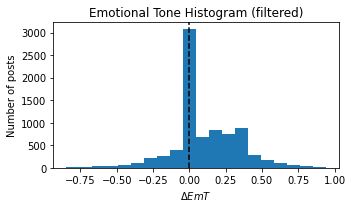

In [ ]:
plot_score_dist([thx_scores],title=['filtered','unfiltered'],n_bins=20)

In [ ]:
# POSTS + COMMENTS
STEP_1 = False
STEP_2 = True
if STEP_1:
    CREATE_FLUCTUATIONS_DF = False
    if DATADIR == BASEDIR+'data/':
        suffix = "_before"
        scores = thx_scores
    else:
        suffix = "_after"
        scores = no_thx_scores

    if CREATE_FLUCTUATIONS_DF:
        score_df,post_only_df = get_fluct_df(post_df,scores,suffix)
    else:
        score_df_after = pickle.load(open(DATADIR  + f"score_fluct_after.pkl",'rb'))
        score_df_before = pickle.load(open(DATADIR  + f"score_fluct_before.pkl",'rb'))
        post_only_df_after = pickle.load(open(DATADIR  + f"post_only_fluct_after.pkl",'rb'))
        post_only_df_before = pickle.load(open(DATADIR  + f"post_only_fluct_before.pkl",'rb'))
if STEP_2:
    CONCATENATE_DFS = False
    if CONCATENATE_DFS:
        final_score_df = pd.merge(score_df_before,score_df_after,how='inner',on=['id'])
        final_score_df.drop(['score_after_x'],axis=1,inplace=True)
        final_score_df.drop(['score_before_y'],axis=1,inplace=True)

        final_post_only_df = pd.merge(post_only_df_before,post_only_df_after,how='inner',on=['id'])
        final_post_only_df.drop(['post_score_after_x'],axis=1,inplace=True)
        final_post_only_df.drop(['post_score_before_y'],axis=1,inplace=True)

        final_score_df.to_pickle(DATADIR + "final_score_fluct_df.pkl")
        final_post_only_df.to_pickle(DATADIR + "final_post_fluct_df.pkl")
    else:
        post_only_df = pd.read_pickle(DATADIR + "final_post_fluct_df.pkl")
        score_fluct_df = pd.read_pickle(DATADIR + "final_score_fluct_df.pkl")

In [ ]:
#sanity check
post_counter = 0
for i in tqdm(range(len(score_fluct_df))):
    if score_fluct_df.iloc[i].id[0] != 'd': # 'd' indicates that the author is a commenter
        try:
            assert (post_only_df.iloc[post_counter].post_score_before_x == score_fluct_df.iloc[i].score_before_x)
            assert (post_only_df.iloc[post_counter].post_score_after_y == score_fluct_df.iloc[i].score_after_y)
        except AssertionError:
            print(post_only_df.iloc[post_counter])
            print(score_fluct_df.iloc[i])
        post_counter += 1


In [ ]:
diff_df = score_fluct_df['score_after_y'] - score_fluct_df['score_before_x']
post_diff_df = post_only_df['post_score_after_y'] - post_only_df['post_score_before_x']

In [ ]:
diff_df = score_fluct_df['score_after_y'] - score_fluct_df['score_before_x']
print(f"Average deviation from original score w.r.t. to all posts/comments: {diff_df.sum()/diff_df.shape[0]}")
print(f"Percentage of posts/comments that deviated from the original score: {(sum(diff_df != 0)/diff_df.shape[0])*100}%")
posts_that_deviate = diff_df[diff_df.index[diff_df != 0]]
print(f"Average deviation from original score w.r.t. to posts/comments that deviate: {posts_that_deviate.sum()/posts_that_deviate.shape[0]}")

Average deviation from original score w.r.t. to all posts/comments: -0.014846666883737956
Percentage of posts/comments that deviated from the original score: 11.166241198651852%
Average deviation from original score w.r.t. to posts/comments that deviate: -0.13296029182613806


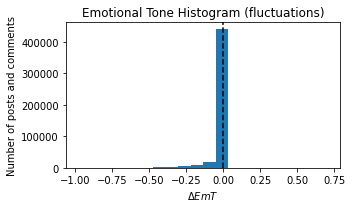

In [ ]:
plot_score_dist([diff_df.to_list()],title=['fluctuations'],n_bins=20)

In [ ]:
z_values_total = calculate_KDF(score_fluct_df)
z_values_deviate = calculate_KDF(score_fluct_df.iloc[posts_that_deviate.index])

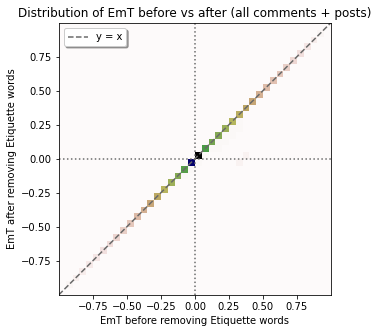

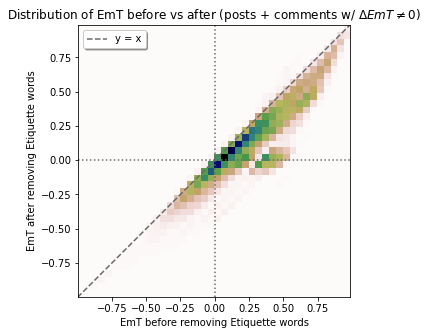

In [ ]:
plot_fluctuations(score_fluct_df,z_values_total,explanation='all comments + posts')
plot_fluctuations(score_fluct_df.iloc[posts_that_deviate.index],z_values_deviate,explanation=r'posts + comments w/ $\Delta EmT \neq 0$')

In [ ]:
post_diff_df = post_only_df['post_score_after_y'] - post_only_df['post_score_before_x']
print(f"Average deviation from original score w.r.t. to all posts: {post_diff_df.sum()/post_diff_df.shape[0]}")
print(f"Percentage of posts that deviated from the original score: {(sum(post_diff_df != 0)/post_diff_df.shape[0])*100}%")
posts_only_that_deviate = post_diff_df[post_diff_df.index[post_diff_df != 0]]
print(f"Average deviation from original score w.r.t. to posts that deviate: {posts_only_that_deviate.sum()/posts_only_that_deviate.shape[0]}")

Average deviation from original score w.r.t. to all posts: -0.003976670625136681
Percentage of posts that deviated from the original score: 10.520903628008613%
Average deviation from original score w.r.t. to posts that deviate: -0.0377978048819879


In [ ]:
post_only_df.columns = ['id','score_before_x','score_after_y']
post_z_values_total = calculate_KDF(post_only_df)
post_z_values_deviate = calculate_KDF(post_only_df.iloc[posts_only_that_deviate.index])

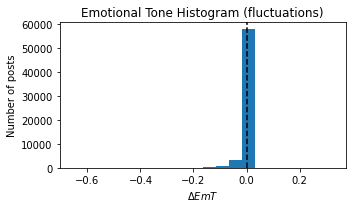

In [ ]:
plot_score_dist([post_diff_df.to_list()],n_bins=20,title=[r'fluctuations'])

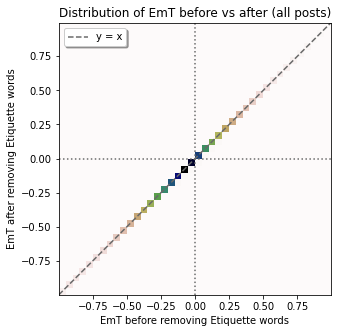

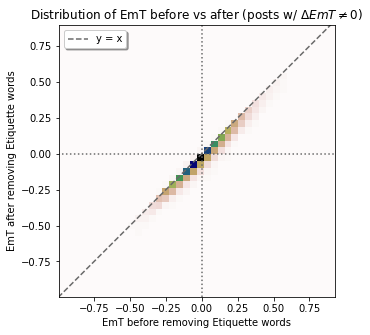

In [ ]:
plot_fluctuations(post_only_df,post_z_values_total,explanation='all posts')
plot_fluctuations(post_only_df.iloc[posts_only_that_deviate.index],post_z_values_deviate,explanation=r'posts w/ $\Delta EmT \neq 0$')
# plot_score_dist(post_diff_df.to_list(),n_bins=20)

In [ ]:
def plot_fluctuations(fluctuations_df,Z,df_x,df_y,title,xlabel,ylabel,explanation='w.r.t comments and posts that deviate'):
    x = fluctuations_df[df_x].to_numpy(dtype=float)
    y = fluctuations_df[df_y].to_numpy(dtype=float)
    xmin = x.min()
    xmax = x.max()
    ymin = y.min()
    ymax = y.max() 
    fig, ax = plt.subplots(1,1,figsize=(5,5))
    ax.imshow(np.rot90(Z), cmap=plt.cm.gist_earth_r,
            extent=[xmin, xmax, ymin, ymax])
    #ax.plot(x, y, 'k.', markersize=2)
    ax.set_xlim([xmin, xmax])

    ax.set_ylim([ymin, ymax])

    plt.plot([0,0],[-1,1],'dimgray',linestyle='dotted')
    plt.plot([-1,1],[0,0],'dimgray',linestyle='dotted')
    #plt.plot([-1,1],[-1,1],'dimgray',label='y = x',linestyle='dashed')
    #legend = ax.legend(loc='upper left', shadow=True, fontsize='medium')
    # ax.scatter(x[:50], y[:50], c='k', s=5, edgecolor='')
    # legend.get_frame().set_facecolor('C0')
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.title(title)
    plt.show()

In [ ]:
score_fluct_df = pd.DataFrame(index=list(range(post_df.shape[0])),columns=['score_before','score_after'])

In [ ]:
for post in range(post_df.shape[0]):
    score_fluct_df.iloc[post]['score_before'] = post_df.iloc[post].score[0]
    score_fluct_df.iloc[post]['score_after'] = post_df.iloc[post].score[post_df.iloc[post].seq_len - 1]


In [ ]:
z_values_fluct = calculate_KDF(score_fluct_df)

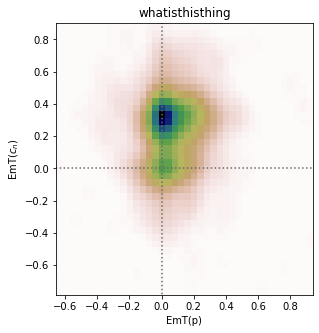

In [ ]:
plot_fluctuations(score_fluct_df,z_values_fluct)

# Experiments for FGCS review

## Normalizing MEAN and XGB w.r.t. real scores

In [ ]:
tmp_df = pd.read_csv(f'{RESULTSDIR}{PREFIX}_{SRC_DATASET}_predictions.csv',index_col=0)
tmp_df.head()


,unchanged,final score,thread ncom,mean,last,model,xgb-mse
10,-0.130042,-0.467600,2,0.012204,0.154450,0.341191,0.149213
17,0.523211,0.072975,5,0.216017,0.137519,0.533828,0.235764
20,0.058143,-0.100950,3,0.062931,0.130650,0.427484,0.199862
34,-0.126900,0.036950,5,-0.025573,0.036950,0.241738,0.080362
46,-0.142029,-0.274950,4,0.020388,-0.136600,0.383980,0.202052


In [ ]:
l1_loss_unnormalized_xgb = (tmp_df['xgb-mse'] - tmp_df['final score']).abs().mean()
l1_loss_unnormalized_mean = (tmp_df['mean'] - tmp_df['final score']).abs().mean()
print(f"XGB UNNORMALIZED L1 LOSS: {l1_loss_unnormalized_xgb}")
print(f"MEAN UNNORMALIZED L1 LOSS: {l1_loss_unnormalized_mean}")

XGB UNNORMALIZED L1 LOSS: 0.25071632889529616
MEAN UNNORMALIZED L1 LOSS: 0.27632694264958596


In [ ]:
mu_true,std_true = tmp_df['final score'].describe().loc[['mean','std']]
mu_pred_xgb,std_pred_xgb = tmp_df['xgb-mse'].describe().loc[['mean','std']]
mu_pred_mean,std_pred_mean = tmp_df['mean'].describe().loc[['mean','std']]

In [ ]:
tmp_df['xgb-mse'] = (tmp_df['xgb-mse'] - mu_pred_xgb)/std_pred_xgb * std_true + mu_true
tmp_df['mean'] = (tmp_df['mean'] - mu_pred_mean)/std_pred_mean * std_true + mu_true

In [ ]:
l1_loss_normalized_xgb = (tmp_df['xgb-mse'] - tmp_df['final score']).abs().mean()
l1_loss_normalized_mean = (tmp_df['mean'] - tmp_df['final score']).abs().mean()
print(f"XGB NORMALIZED L1 LOSS: {l1_loss_normalized_xgb}")
print(f"MEAN NORMALIZED L1 LOSS: {l1_loss_normalized_mean}")

XGB NORMALIZED L1 LOSS: 0.31494926066284057
MEAN NORMALIZED L1 LOSS: 0.32675626053834467


In [ ]:
def calculate_KDF(fluctuations_df,df_y):

    x = fluctuations_df['final score'].to_numpy(dtype=float)
    y = fluctuations_df[df_y].to_numpy(dtype=float)
    xmin = x.min()
    xmax = x.max()
    ymin = y.min()
    ymax = y.max() 
    # X, Y = np.mgrid[xmin:xmax:100j, ymin:ymax:100j]
    X, Y = np.mgrid[xmin:xmax:40j, ymin:ymax:40j]
    positions = np.vstack([X.ravel(), Y.ravel()])
    values = np.vstack([x, y])
    kernel = stats.gaussian_kde(values)
    Z = np.reshape(kernel(positions).T, X.shape)
    return Z

In [ ]:
def plot_dist(fluctuations_df,subreddits,axs_list):
    fig, axsl = plt.subplots(4,2,figsize=(4,8),sharey=True,tight_layout=True)
    fig.text(0.6 , -0.01, r'EmT($c_n$) (true value)', ha='center', fontsize='medium')
    fig.text(-0.01, 0.5 , 'prediction', va='center', rotation='vertical', fontsize='medium')
    for ax, col in zip(axsl[0], axs_list[:]):
        ax.set_title(col.upper(), size='large')
    for ax, row in zip(axsl[:,0], subreddits):
    # ax.yaxis.set_label_position("right")
        ax.set_ylabel(subreddit2title[row.lower()], rotation=0, size='large', horizontalalignment='right')
    for indx,axs in enumerate(axsl):
        for ind,ax in enumerate(axs):  
            x = fluctuations_df[axs_list[ind]].to_numpy(dtype=float)
            y = fluctuations_df['final score'].to_numpy(dtype=float)
            Z = calculate_KDF(tmp_df.loc[subreddit2range[subreddits[indx]]],axs_list[ind])
            xmin = x.min()
            xmax = x.max()
            ymin = y.min()
            ymax = y.max() 
            ax.imshow(np.rot90(Z), cmap=plt.cm.gist_earth_r,
                    extent=[xmin, xmax, ymin, ymax],aspect='auto')

            #ax.plot(x, y, 'k.', markersize=2)
            ax.set_xlim([xmin, xmax])
            ax.set_ylim([ymin, ymax])
            # ax.plot([0,0],[xmin,ymax],'dimgray',linestyle='dotted')
            # ax.plot([xmin,ymax],[0,0],'dimgray',linestyle='dotted')
            ax.axvline(color='dimgray',linestyle='dashed')
            ax.axhline(color='dimgray',linestyle='dashed')
            # ax.set_xlabel(r'$EmT(c_n)$')
            # ax.set_ylabel('predictions')
    cb = plt.colorbar(            ax.imshow(np.rot90(Z), cmap=plt.cm.gist_earth_r,
                    extent=[xmin, xmax, ymin, ymax],aspect='auto'), cax = fig.add_axes([0.3, 1.01, .6, 0.01]), orientation='horizontal')
    cb.ax.set_title('density', size='large')
    plt.show()

/usr/local/lib/python3.7/dist-packages/IPython/core/pylabtools.py:125: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.canvas.print_figure(bytes_io, **kw)


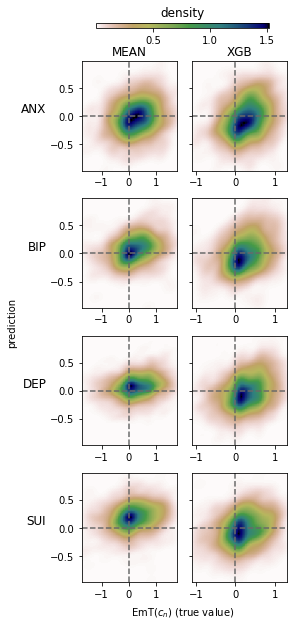

In [ ]:
plot_dist(tmp_df,SUBREDDITS,['mean','xgb'])

## Robustness tests

### Generating 5 different splits

In [16]:
def reset_seeds_test(SEED):
  random.seed(SEED)
  np.random.seed(SEED)
  torch.manual_seed(SEED)
  torch.backends.cudnn.deterministic = True
  torch.cuda.manual_seed(SEED)
  torch.backends.cudnn.deterministic = True

In [17]:
def split_indices_test(post_df,seed):
  
    nthreads = len(post_df)     # number of threads
    if STRATIFIED:
        y = post_df.apply(lambda p: p.score[p.seq_len-1], axis=1).values
        bins = np.floor((y - MIN_VALUE)/BIN_WIDTH).astype(int)

        reset_seeds_test(seed)
        fold_size = int(0.1*len(y))
        remaining_inds,valid_inds,_,_ = train_test_split(np.arange(nthreads),y,test_size=fold_size,stratify=bins)
        train_inds,test_inds,_,_ = train_test_split(remaining_inds,y[remaining_inds],test_size=fold_size,stratify=bins[remaining_inds])

        train_inds = np.sort(train_inds).tolist()
        valid_inds = np.sort(valid_inds).tolist()
        test_inds  = np.sort(test_inds).tolist()

    else:
        # divide randomly
        reset_seeds_test(seed)
        assigned_set = np.random.multinomial(1,[.8,.1,.1],nthreads)
        
        train_inds = list(np.argwhere(assigned_set[:,0]).ravel())
        valid_inds = list(np.argwhere(assigned_set[:,1]).ravel())
        test_inds  = list(np.argwhere(assigned_set[:,2]).ravel())

    print(f"Number of training examples: {len(train_inds)}")
    print(f"Number of validation examples: {len(valid_inds)}")
    print(f"Number of testing examples: {len(test_inds)}")

    return train_inds, valid_inds, test_inds

In [18]:
seeds = [124,125,126,127,128]
test_errors = []

In [21]:

# TODO: all the constants should be defined or computed in the first cell
suffix='_distilbert_filtered_posts.pkl'
# if LOW_MEMORY:
#     df_list = list()
#     for subreddit in SUBREDDITS:
#         curr_df = pd.read_pickle(DATADIR+subreddit+suffix)
#         curr_df.drop(columns=['features'],inplace=True)
#         df_list.append(curr_df)
#     post_df = pd.concat((df_list[i]) \ for i in range(len(SUBREDDITS)))
# else:
post_df = pd.concat((load_df(DATADIR+subreddit+suffix, MAX_THREAD_LEN) \
                        for subreddit in SUBREDDITS),keys=SUBREDDITS)

# post_df = post_df.sample(10000)
# print(post_df.loc[subreddit2post[SUBREDDITS[0]]])

# TODO: it seems that we are keeping everything if KEEP_TEXT. is this really necessary?
if not KEEP_TEXT:
  post_df = post_df[['created_utc', 'seq_len','score', 'features', 'filtered_seqlen','valid_branches']]

# new strategy to construct observations: follow branches of every discussion tree 
#post_df.drop(columns=['valid_branches'],inplace=True)

if FILTERED:
    # dropna on filtered_seqlen, then replace seq_len by filtered_seqlen
    post_df.dropna(subset=['filtered_seqlen'], inplace=True)
    post_df.filtered_seqlen = post_df.filtered_seqlen.astype(int)

    post_df.drop(columns='seq_len',inplace=True)
    post_df.rename(columns={'filtered_seqlen':'seq_len'},inplace=True)
else:
    post_df.drop(columns='filtered_seqlen',inplace=True)

print(f'Fraction of threads that had to be truncated: {(post_df.seq_len>(MAX_THREAD_LEN+1)).mean()}')


Loading /content/drive/My Drive/MentalHealthShared/data/Anxiety_distilbert_filtered_posts.pkl...
Loading /content/drive/My Drive/MentalHealthShared/data/bipolar_distilbert_filtered_posts.pkl...
Loading /content/drive/My Drive/MentalHealthShared/data/depression_distilbert_filtered_posts.pkl...
Loading /content/drive/My Drive/MentalHealthShared/data/SuicideWatch_distilbert_filtered_posts.pkl...
Fraction of threads that had to be truncated: 0.004182708303626598


In [22]:
#PART 1
print("PART1")
prefix = 'unnorm_'
shape = [1,post_df.iloc[0].features.shape[-1]]
src_m = torch.zeros(shape)
src_s = torch.ones(shape)
score_m = float(src_m[0,-2])
score_s = float(src_s[0,-2])

print(f'Average score in dataset is {score_m}')

subreddit2range = get_subreddit_range(post_df)
print(subreddit2range[SUBREDDITS[0]])

suffix = "random"
if STRATIFIED:
    suffix += '_strat'

# compute weights for Weighted L1 Loss
subreddit2weights = get_subreddit_weights(post_df, BIN_WIDTH,MIN_VALUE)
print(subreddit2weights)

#PART 2
print("PART2")

print('Creating src')

print('Creating y')
y = torch.Tensor(post_df.apply(lambda p: p.score[p.seq_len-1], axis=1).values)

print('Creating src_len_series')
src_len_series = post_df.seq_len-1
max_length=MAX_THREAD_LEN

src = nn.utils.rnn.pad_sequence(
[ (p.features[:min(MAX_THREAD_LEN,p.seq_len-1),:]-src_m)/src_s for index, p in post_df.iterrows()], batch_first=True)
print(f"GRU src tensor size: {src.size()}")

print(f'y tensor size: {y.size()}')
tgt = None

print('Creating dataset')
if USE_GRU:
    #dataset = createTensorDataset(src, src_len_series, y, tgt=tgt, max_length=max_length) # all threads, lim 63 comments
    dataset = createTensorDataset(src, src_len_series, y, max_length=max_length) # all threads, lim 63 comments
    del src

del src_len_series, tgt, y

PART1
Average score in dataset is 0.0
slice(0, 11956, None)
{'all': tensor([28.1145, 11.2911,  5.4015,  2.4045,  1.2764,  0.7067,  1.0117,  1.5064,
         3.0316, 10.6168]), 'Anxiety': tensor([42.7000, 17.7126,  7.0123,  3.0040,  1.3743,  0.7531,  0.8850,  1.2454,
         2.8535,  9.4514]), 'SuicideWatch': tensor([18.3787,  8.2006,  4.2482,  1.8874,  1.0884,  0.6727,  1.2003,  2.0198,
         3.9991, 13.3577]), 'bipolar': tensor([77.7619, 17.3723,  7.3229,  2.8599,  1.2251,  0.6439,  0.9646,  1.4451,
         3.5969, 14.8455]), 'depression': tensor([26.0078, 10.4848,  5.1658,  2.3935,  1.3543,  0.7238,  1.0143,  1.4845,
         2.7013,  9.5060])}
PART2
Creating src
Creating y
Creating src_len_series
GRU src tensor size: torch.Size([63117, 64, 770])
y tensor size: torch.Size([63117])
Creating dataset


In [ ]:
if type(SUBREDDITS) != list:
    SUBREDDITS = list(SUBREDDITS)
N_EPOCHS=20 # maximum number of epochs to train the model
PATIENCE=3 # constant that controls the Early Stopping mechanism of the grid search for the GRU model
SRC_DATASET='all'
PREFIX ='random'
if STRATIFIED:
    PREFIX += '_strat'
results_filename=f'{RESULTSDIR}{PREFIX}_{SRC_DATASET}_b{int(2./BIN_WIDTH):02}_f{FILTERED}_n{N_EPOCHS}_p{PATIENCE}_mGRUv1.pkl'
print(f'Results file is {results_filename}')
for curr_seed in seeds:
    train_inds, valid_inds, test_inds  = split_indices_test(post_df,curr_seed)

    #PART 3
    print("PART3")
    train_loader = DataLoader(Subset(dataset,train_inds), batch_size=32, shuffle=True, num_workers=1)
    valid_loader = DataLoader(Subset(dataset,valid_inds), batch_size=len(valid_inds), shuffle=False, num_workers=1)
    test_loader  = DataLoader(Subset(dataset, test_inds), batch_size=len(test_inds), shuffle=False, num_workers=1)

    #PART 4
    print("PART4")
# load best model

    RETRAIN = False
    USE_LOSS_BEST = False
    USE_BEST_VALIDATION = True
    criterion = WeightedL1Loss(subreddit2weights['all'], BIN_WIDTH, MIN_VALUE)
    #criterion = nn.MSELoss()
    criterion_name = lambda x: x.__class__.__name__.split('.')[-1]


    # see if the file with best params is available
    # results_df = pd.read_pickle(results_filename)

    if USE_LOSS_BEST:
        best_result = results_df.loc[results_df[criterion_name(criterion)+'_best'].argmin()]
    else:
        best_result = results_df.loc[results_df[criterion_name(criterion)].argmin()]

    # uncomment to load specific model instead
    # best_result = results_df.iloc[0]
    if RETRAIN:
        reset_seeds()
        model = models.GRUSentiment(best_result.params)
        _, valid_loss, _ = train_over_nepochs( model, train_loader, valid_loader,
                                            criterion=criterion, device=device,
                                            patience=3, n_epochs=N_EPOCHS)

        if USE_BEST_VALIDATION:
            model.load_state_dict(torch.load('checkpoint.pt', map_location=lambda storage, loc: storage))

    else:
        model = models.GRUSentiment(best_result.params)
        if USE_BEST_VALIDATION:
            model.load_state_dict(best_result.para)
        else:
            model.load_state_dict(best_result.para_best)

    model.to(device)

    test_loss, outputs = evaluate(model, iter(test_loader), criterion=criterion, device=device, return_predictions=True)
    model_yhat = outputs[0][0].cpu().numpy() # extract data from outputs
    ilocs = outputs[0][2].cpu().numpy()
    model_series = pd.Series(model_yhat.ravel(),index=ilocs)
    del outputs

    # print model params
    print(best_result.params)
    print(f'Test loss: {test_loss:.3f}')
    test_errors.append(test_loss)

Results file is /content/drive/My Drive/MentalHealthShared/results/random_strat_all_b10_fTrue_n20_p3_mGRUv1.pkl
Number of training examples: 50495
Number of validation examples: 6311
Number of testing examples: 6311
PART3
PART4
{'input_size': 770, 'output_size': 1, 'uses_two_series_as_input': False, 'dropout_out': 0.0, 'hidden_size': 64, 'num_layers': 2, 'dropout_rnn': 0.0, 'bidirectional': False}
Test loss: 0.726
Number of training examples: 50495
Number of validation examples: 6311
Number of testing examples: 6311
PART3
PART4
{'input_size': 770, 'output_size': 1, 'uses_two_series_as_input': False, 'dropout_out': 0.0, 'hidden_size': 64, 'num_layers': 2, 'dropout_rnn': 0.0, 'bidirectional': False}
Test loss: 0.720
Number of training examples: 50495
Number of validation examples: 6311
Number of testing examples: 6311
PART3
PART4
{'input_size': 770, 'output_size': 1, 'uses_two_series_as_input': False, 'dropout_out': 0.0, 'hidden_size': 64, 'num_layers': 2, 'dropout_rnn': 0.0, 'bidirectio

In [ ]:
print("Results:")
print(f"Test Errors mean: {np.mean(test_errors)}")
print(f"Test Errors std: {np.std(test_errors)}")

### Ramdomly initializing weights

In [ ]:
seeds = [124,125,126,127,128]
test_errors2 = []

In [ ]:

train_inds, valid_inds, test_inds  = split_indices_test(post_df,1234)
#PART 3
print("PART3")
train_loader = DataLoader(Subset(dataset,train_inds), batch_size=32, shuffle=True, num_workers=1)
valid_loader = DataLoader(Subset(dataset,valid_inds), batch_size=len(valid_inds), shuffle=False, num_workers=1)
test_loader  = DataLoader(Subset(dataset, test_inds), batch_size=len(test_inds), shuffle=False, num_workers=1)
for curr_seed in seeds:
    #PART 4
    print("PART4")
    # load best model
    # RETRAIN = True
    # USE_LOSS_BEST = False
    # USE_BEST_VALIDATION = True
    criterion = WeightedL1Loss(subreddit2weights['all'], BIN_WIDTH, MIN_VALUE)
    #criterion = nn.MSELoss()
    criterion_name = lambda x: x.__class__.__name__.split('.')[-1]
    # see if the file with best params is available
    results_df = pd.read_pickle(results_filename)
    reset_seeds_test(curr_seed)
    best_result = results_df.loc[results_df[criterion_name(criterion)].argmin()]
    model = models.GRUSentiment(best_result.params)
    _, valid_loss, _ = train_over_nepochs( model, train_loader, valid_loader,
                                        criterion=criterion, device=device,
                                        patience=3, n_epochs=N_EPOCHS)
  

    model.load_state_dict(torch.load('checkpoint.pt', map_location=lambda storage, loc: storage))
    model.to(device)
    test_loss, outputs = evaluate(model, iter(test_loader), criterion=criterion, device=device, return_predictions=True)
    model_yhat = outputs[0][0].cpu().numpy() # extract data from outputs
    ilocs = outputs[0][2].cpu().numpy()
    model_series = pd.Series(model_yhat.ravel(),index=ilocs)
    del outputs
    # print model params
    print(best_result.params)
    print(f'Test loss: {test_loss:.3f}')
    test_errors2.append(test_loss)

In [ ]:
print("Results:")
print(f"Test Errors mean: {np.mean(test_errors2)}")
print(f"Test Errors std: {np.std(test_errors2)}")